# Modules and Functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install deepface

In [2]:
import os
import numpy as np
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
#from deepface import DeepFace as df
from google.colab.patches import cv2_imshow
pd.options.mode.chained_assignment = None

In [ ]:
def make_pairs(data):
    pairs = []
    labels = []
    for i in tqdm(range(len(data['Name']))):
        current_label = data.loc[i, 'Label']
        pos_candidates = np.array(data.loc[(data['Label'] == current_label) & (data.index != i), 'Path'])
        if len(pos_candidates) >= 1:
            pos_choice = np.random.choice(pos_candidates)
            pairs.append([data.loc[i, 'Path'], pos_choice])
            labels.append(True)

        neg_candidates = np.array(data.loc[data['Label'] != current_label, 'Path'])
        if len(neg_candidates) >= 1:
            neg_choice = np.random.choice(neg_candidates)
            pairs.append([data.loc[i, 'Path'], neg_choice])
            labels.append(False)
    return (np.array(pairs), np.array(labels))

In [ ]:
def verify(img1_path, img2_path, model_name):
    output = df.verify(img1_path, img2_path, model_name = model_name)
    prediction = output['verified']
    distance = output['distance']
    return prediction, distance

In [ ]:
def sift_extraction(path_1, path_2):
  img1 = cv2.imread(path_1)
  img2 = cv2.imread(path_2)
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)

  if descriptors_1 is not None and descriptors_2 is not None:
    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key = lambda x: x.distance)
  else:
    matches = None

  if descriptors_1 is None:
    descriptors_1 = []
  if descriptors_2 is None:
    descriptors_2 = []
  if matches is None:
    matches = []

  return len(descriptors_1), len(descriptors_2), len(matches)

# Best Model Selection

## DeepFace Models Comparison

In [ ]:
folder = '/content/drive/MyDrive/all_images_2'
all_images = os.listdir('/content/drive/MyDrive/all_images_2')
unique_names = set([' '.join(all_images[i].split('_')[:2]) for i in range(len(all_images))])
img_label = dict()
for i in range(len(unique_names)):
    img_label[list(unique_names)[i]] = i

images_data = pd.DataFrame()

for i in tqdm(range(len(all_images))):
  image_name = ' '.join(all_images[i].split('_')[:2])
  label = img_label[image_name]
  image_path = folder + '/' + all_images[i]

  images_data.loc[i, 'Name'] = image_name
  images_data.loc[i, 'Label'] = label
  images_data.loc[i, 'Path'] = image_path

images_data['Label'] = images_data['Label'].astype('str')
images_data.head()

100%|██████████| 7608/7608 [00:05<00:00, 1270.47it/s]


,Name,Label,Path
0,Sheryl Crow,520.0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...
1,Hamid Karzai,889.0,/content/drive/MyDrive/all_images_2/Hamid_Karz...
2,Colin Powell,393.0,/content/drive/MyDrive/all_images_2/Colin_Powe...
3,Naji Sabri,720.0,/content/drive/MyDrive/all_images_2/Naji_Sabri...
4,Junichiro Koizumi,738.0,/content/drive/MyDrive/all_images_2/Junichiro_...


In [ ]:
(all_pairs, all_labels) = make_pairs(images_data)

100%|██████████| 7608/7608 [00:16<00:00, 475.23it/s]


In [ ]:
# Performance accuracy of VGG16 on a subsample

n = 20
predictions = []
distances = []
true_labels = []
paths = []
indexes = np.random.choice(np.arange(len(all_pairs)), size = n)

pairs = all_pairs[indexes]
labels = all_labels[indexes]

subsample = pd.DataFrame()
for i in tqdm(range(len(pairs))):
  try:
    output = df.verify(cv2.imread(pairs[i][0]), cv2.imread(pairs[i][1]), 'VGG-Face')
    paths.append(pairs[i])
    true_labels.append(labels[i])
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    pass

subsample['Paths'] = paths
subsample['Label'] = true_labels
subsample['Prediction'] = predictions
subsample['Distance'] = distances

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


In [ ]:
subsample.head()

,Paths,Label,Prediction,Distance
0,[/content/drive/MyDrive/all_images_2/Al_Sharpt...,True,True,0.246624
1,[/content/drive/MyDrive/all_images_2/Robert_Du...,False,False,0.447297
2,[/content/drive/MyDrive/all_images_2/Joseph_Bi...,True,True,0.243803
3,[/content/drive/MyDrive/all_images_2/Monica_Se...,False,False,0.543350
4,[/content/drive/MyDrive/all_images_2/Colin_Pow...,False,False,0.664498


In [ ]:
models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]

n = 1000
indexes = np.random.choice(np.arange(len(all_pairs)), size = n)
pairs = all_pairs[indexes]
labels = all_labels[indexes]
all_models = pd.DataFrame()

for i in tqdm(range(len(models))):

  model = models[i]
  single_model = pd.DataFrame()
  paths_1 = []
  paths_2 = []
  true_labels = []
  predictions = []
  distances = []

  for j in range(len(pairs)):

    try:
      output = df.verify(cv2.imread(pairs[j][0]), cv2.imread(pairs[j][1]), model)
      paths_1.append(pairs[j][0])
      paths_2.append(pairs[j][1])
      true_labels.append(labels[j])
      predictions.append(output['verified'])
      distances.append(output['distance'])
    except:
      pass

  single_model['Path_1'] = paths_1
  single_model['Path_2'] = paths_2
  single_model['Label'] = true_labels
  single_model['Prediction'] = predictions
  single_model['Distance'] = distances
  single_model['Model'] = model

  all_models = pd.concat([all_models, single_model])

100%|██████████| 9/9 [58:45<00:00, 391.72s/it]


In [ ]:
# all_models.to_csv('/content/drive/MyDrive/Face_Comparison_Models.csv')

In [ ]:
all_models = pd.read_csv('/content/drive/MyDrive/Face_Comparison_Models.csv')

In [ ]:
models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]

for i in range(len(models)):
    try:
        model = models[i]
        print(model)
        tot = len(all_models.loc[all_models['Model'] == model, 'Label'])
        print('Sample size: ', str(len(all_models.loc[all_models['Model'] == model, 'Label'])))
        print('Missing: ', str(100 - tot*100/1000))
        print('Accuracy: ', str(len(all_models.loc[(all_models['Label'] == all_models['Prediction']) & (all_models['Model'] == model), 'Label'])*100/tot))
        print('False Positive: ', str(len(all_models.loc[(all_models['Prediction'] == 1) & (all_models['Label'] == 0) & (all_models['Model'] == model), 'Label'])*100/tot))
        print('False Negative: ', str(len(all_models.loc[(all_models['Prediction'] == 0) & (all_models['Label'] == 1) & (all_models['Model'] == model), 'Label'])*100/tot))
        print('')
    except:
        print('No samples of ', model)
        print('')

VGG-Face
Sample size:  950
Missing:  5.0
Accuracy:  82.3157894736842
False Positive:  12.631578947368421
False Negative:  5.052631578947368

Facenet
Sample size:  950
Missing:  5.0
Accuracy:  84.63157894736842
False Positive:  0.21052631578947367
False Negative:  15.157894736842104

Facenet512
Sample size:  950
Missing:  5.0
Accuracy:  75.47368421052632
False Positive:  0.0
False Negative:  24.526315789473685

OpenFace
Sample size:  950
Missing:  5.0
Accuracy:  51.68421052631579
False Positive:  0.0
False Negative:  48.31578947368421

DeepFace
Sample size:  950
Missing:  5.0
Accuracy:  60.63157894736842
False Positive:  3.0526315789473686
False Negative:  36.31578947368421

DeepID
Sample size:  0
Missing:  100.0
No samples of  DeepID

ArcFace
Sample size:  950
Missing:  5.0
Accuracy:  93.36842105263158
False Positive:  0.9473684210526315
False Negative:  5.684210526315789

Dlib
Sample size:  0
Missing:  100.0
No samples of  Dlib

SFace
Sample size:  950
Missing:  5.0
Accuracy:  86.0
Fa

## ArcFace Training Set

### Creation

In [ ]:
folder = '/content/drive/MyDrive/all_images_2'
all_images = os.listdir('/content/drive/MyDrive/all_images_2')
unique_names = set([' '.join(all_images[i].split('_')[:2]) for i in range(len(all_images))])
img_label = dict()
for i in range(len(unique_names)):
    img_label[list(unique_names)[i]] = i

images_data = pd.DataFrame()

for i in tqdm(range(len(all_images))):
  image_name = ' '.join(all_images[i].split('_')[:2])
  label = img_label[image_name]
  image_path = folder + '/' + all_images[i]

  images_data.loc[i, 'Name'] = image_name
  images_data.loc[i, 'Label'] = label
  images_data.loc[i, 'Path'] = image_path

images_data['Label'] = images_data['Label'].astype('str')
images_data.head()

100%|██████████| 7608/7608 [00:08<00:00, 901.89it/s]


,Name,Label,Path
0,Sheryl Crow,490.0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...
1,Hamid Karzai,665.0,/content/drive/MyDrive/all_images_2/Hamid_Karz...
2,Colin Powell,142.0,/content/drive/MyDrive/all_images_2/Colin_Powe...
3,Naji Sabri,638.0,/content/drive/MyDrive/all_images_2/Naji_Sabri...
4,Junichiro Koizumi,188.0,/content/drive/MyDrive/all_images_2/Junichiro_...


In [ ]:
(all_pairs, all_labels) = make_pairs(images_data)

100%|██████████| 7608/7608 [00:19<00:00, 384.03it/s]


In [ ]:
paths_1 = [all_pairs[i][0] for i in range(len(all_pairs))]
paths_2 = [all_pairs[i][1] for i in range(len(all_pairs))]
labels = [all_labels[i] for i in range(len(all_labels))]

arcface_training_data = pd.DataFrame()
arcface_training_data['Path_1'] = paths_1
arcface_training_data['Path_2'] = paths_2
arcface_training_data['Label'] = labels

#arcface_training_data.to_csv('/content/drive/MyDrive/all_images_2/arcface_training_data.csv')

In [ ]:
all_data = pd.read_csv('/content/drive/MyDrive/all_images_2/arcface_training_data.csv').drop('Unnamed: 0', axis = 1)
print(all_data.shape)
all_data.head()

(15216, 3)


,Path_1,Path_2,Label
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False
2,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/Hamid_Karz...,True
3,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False
4,/content/drive/MyDrive/all_images_2/Colin_Powe...,/content/drive/MyDrive/all_images_2/Colin_Powe...,True


In [ ]:
n1 = 4000
n2 = 8000
n3 = 12000
predictions = []
distances = []
true_labels = []
paths_1 = []
paths_2 =  []

all_pairs = [[all_data.loc[i, 'Path_1'], all_data.loc[i, 'Path_2']] for i in range(all_data.shape[0])]
all_labels = [all_data.loc[i, 'Label'] for i in range(all_data.shape[0])]

arcface_set = pd.DataFrame()
for i in tqdm(range(n3, len(all_pairs))):
  try:
    output = df.verify(cv2.imread(all_pairs[i][0]), cv2.imread(all_pairs[i][1]), 'ArcFace')
    paths_1.append(all_pairs[i][0])
    paths_2.append(all_pairs[i][1])
    true_labels.append(all_labels[i])
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    pass

arcface_set['Path_1'] = paths_1
arcface_set['Path_2'] = paths_2
arcface_set['Label'] = true_labels
arcface_set['Prediction'] = predictions
arcface_set['Distance'] = distances

arcface_set.to_csv('/content/drive/MyDrive/ArcFace_Training_Set_4.csv')


100%|██████████| 3216/3216 [47:37<00:00,  1.13it/s]


In [ ]:
arc_1 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set.csv')
arc_2 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_2.csv')
arc_3 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_3.csv')
arc_4 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_4.csv')

arc_final = pd.concat([arc_1, arc_2, arc_3, arc_4]).drop('Unnamed: 0', axis = 1).drop_duplicates(['Path_1', 'Path_2'])
print(arc_final.shape)
arc_final.head()

(14445, 5)


,Path_1,Path_2,Label,Prediction,Distance
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761
2,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842
3,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Naji_Sabri...,True,True,0.018809
4,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Gerhard_Sc...,False,False,0.819620


In [ ]:
#arc_final.to_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv')

### Results

In [ ]:
arc_final = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv')

tot = arc_final.shape[0]
print('Sample size: ', tot)
print('Accuracy: ', str(len(arc_final.loc[(arc_final['Label'] == arc_final['Prediction']), 'Label'])*100/tot))
print('False Positive: ', str(len(arc_final.loc[(arc_final['Prediction'] == 1) & (arc_final['Label'] == 0), 'Label'])*100/tot))
print('False Negative: ', str(len(arc_final.loc[(arc_final['Prediction'] == 0) & (arc_final['Label'] == 1), 'Label'])*100/tot))

Sample size:  14445
Accuracy:  94.01869158878505
False Positive:  0.9345794392523364
False Negative:  5.046728971962617


# Web Scraping Accuracy

## ArcFace - LinkedIn

In [ ]:
download_folder = '/content/drive/MyDrive/downloaded_images'
down_images = os.listdir(download_folder)

download_data = pd.DataFrame()
download_paths = []
download_names = []

for i in tqdm(range(len(down_images))):
  download_paths.append(download_folder + '/' + down_images[i])
  download_names.append(down_images[i][:-13])

download_data['Path_Down'] = download_paths
download_data['Name'] = download_names

print(download_data.shape)
download_data.head()

100%|██████████| 3642/3642 [00:00<00:00, 246811.46it/s]

(3642, 2)


,Path_Down,Name
0,/content/drive/MyDrive/downloaded_images/Megan...,Megan Keenan
1,/content/drive/MyDrive/downloaded_images/Megan...,Megan L
2,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lacy
3,/content/drive/MyDrive/downloaded_images/Megan...,Megan Legband
4,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lucille Brown


In [ ]:
screenshots_folder = '/content/drive/MyDrive/Screenshots'
screenshots = os.listdir(screenshots_folder)

screenshots_data = pd.DataFrame()
screenshots_paths = []
screenshots_names = []

for i in tqdm(range(len(screenshots))):
  screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
  screenshots_names.append(screenshots[i][:-4])

screenshots_data['Path_Screen'] = screenshots_paths
screenshots_data['Name'] = screenshots_names

print(screenshots_data.shape)
screenshots_data.head()

100%|██████████| 3758/3758 [00:00<00:00, 389728.87it/s]

(3758, 2)


,Path_Screen,Name
0,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes
1,/content/drive/MyDrive/Screenshots/Erik B. Kun...,Erik B. Kundu
2,/content/drive/MyDrive/Screenshots/Mason E. Re...,Mason E. Reynolds
3,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark
4,/content/drive/MyDrive/Screenshots/Eric Fisher...,Eric Fisher


In [ ]:
final_data = pd.merge(download_data, screenshots_data, on = 'Name')
print(final_data.shape)
final_data.head()

(2979, 3)


,Path_Down,Name,Path_Screen
0,/content/drive/MyDrive/downloaded_images/Megan...,Megan Keenan,/content/drive/MyDrive/Screenshots/Megan Keena...
1,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lacy,/content/drive/MyDrive/Screenshots/Megan Lacy.png
2,/content/drive/MyDrive/downloaded_images/Megan...,Megan Legband,/content/drive/MyDrive/Screenshots/Megan Legba...
3,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lucille Brown,/content/drive/MyDrive/Screenshots/Megan Lucil...
4,/content/drive/MyDrive/downloaded_images/Megan...,Megan McGuiggan,/content/drive/MyDrive/Screenshots/Megan McGui...


In [ ]:
# ArcFace Model

distances = []
predictions = []

for i in tqdm(range(len(final_data['Name']))):
  try:
    output = df.verify(cv2.imread(final_data.loc[i, 'Path_Down']), cv2.imread(final_data.loc[i, 'Path_Screen']), 'ArcFace')
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    predictions.append(None)
    distances.append(None)

final_data['Prediction'] = predictions
final_data['Distance'] = distances

100%|██████████| 2979/2979 [34:05<00:00,  1.46it/s]


In [ ]:
final_data.head()

,Path_Down,Name,Path_Screen,Prediction,Distance
0,/content/drive/MyDrive/downloaded_images/Megan...,Megan Keenan,/content/drive/MyDrive/Screenshots/Megan Keena...,False,0.705291
1,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lacy,/content/drive/MyDrive/Screenshots/Megan Lacy.png,None,NaN
2,/content/drive/MyDrive/downloaded_images/Megan...,Megan Legband,/content/drive/MyDrive/Screenshots/Megan Legba...,None,NaN
3,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lucille Brown,/content/drive/MyDrive/Screenshots/Megan Lucil...,True,0.165654
4,/content/drive/MyDrive/downloaded_images/Megan...,Megan McGuiggan,/content/drive/MyDrive/Screenshots/Megan McGui...,False,0.956728


In [ ]:
#final_data.to_csv('/content/drive/MyDrive/ArcFace_LinkedIn_Accuracy.csv')

## ArcFace Results - LinkedIn

In [ ]:
arcface = pd.read_csv('/content/drive/MyDrive/ArcFace_LinkedIn_Accuracy.csv').drop('Unnamed: 0', axis = 1)
arcface.head()

,Path_Down,Name,Path_Screen,Prediction,Distance
0,/content/drive/MyDrive/downloaded_images/Megan...,Megan Keenan,/content/drive/MyDrive/Screenshots/Megan Keena...,False,0.705291
1,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lacy,/content/drive/MyDrive/Screenshots/Megan Lacy.png,NaN,NaN
2,/content/drive/MyDrive/downloaded_images/Megan...,Megan Legband,/content/drive/MyDrive/Screenshots/Megan Legba...,NaN,NaN
3,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lucille Brown,/content/drive/MyDrive/Screenshots/Megan Lucil...,True,0.165654
4,/content/drive/MyDrive/downloaded_images/Megan...,Megan McGuiggan,/content/drive/MyDrive/Screenshots/Megan McGui...,False,0.956728


In [ ]:
tot = arcface.shape[0]
is_null = arcface[arcface['Prediction'].isnull()].shape[0]
not_null = arcface[arcface['Prediction'].notnull()].shape[0]
positive = arcface[arcface['Prediction'] == True].shape[0]
negative = arcface[arcface['Prediction'] == False].shape[0]

print('% of null comparisons: ', str(is_null*100/tot))
print('% of positive pairs: ', str(positive*100/not_null))
print('% of negative pairs: ', str(negative*100/not_null))

% of null comparisons:  11.44679422625042
% of positive pairs:  41.394996209249435
% of negative pairs:  58.605003790750565


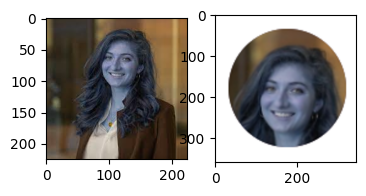

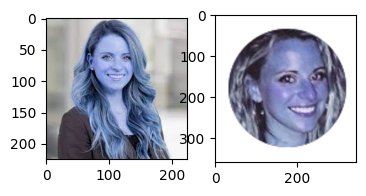

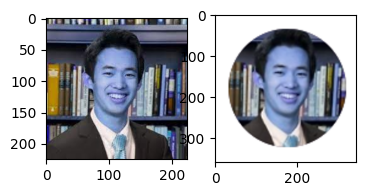

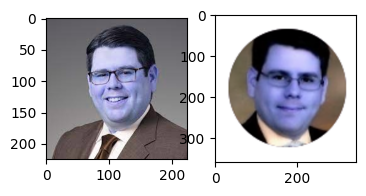

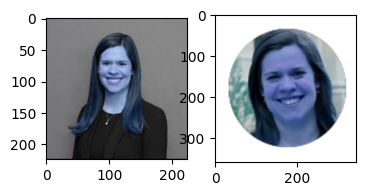

In [ ]:
positive = np.random.choice(np.where(arcface['Prediction'] == True)[0], size = 5)
for index in positive:
  plt.figure(figsize=(4, 2))
  pair = (cv2.imread(arcface.loc[index, 'Path_Down']), cv2.imread(arcface.loc[index, 'Path_Screen']))
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

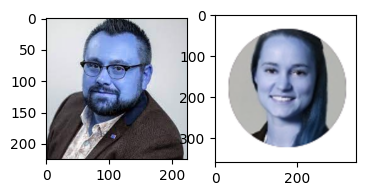

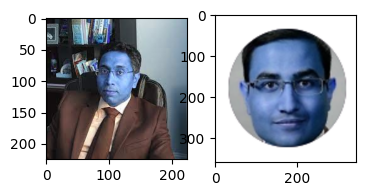

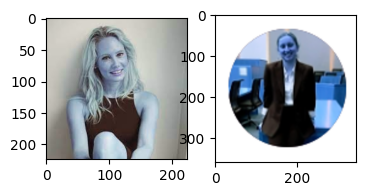

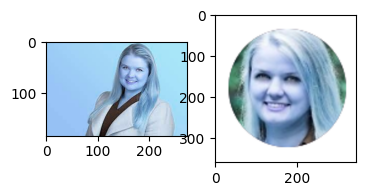

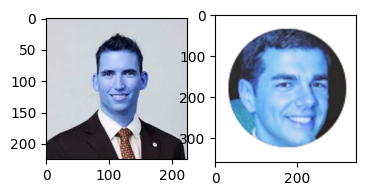

In [ ]:
negative = np.random.choice(np.where(arcface['Prediction'] == False)[0], size = 5)
for index in negative:
  plt.figure(figsize=(4, 2))
  pair = (cv2.imread(arcface.loc[index, 'Path_Down']), cv2.imread(arcface.loc[index, 'Path_Screen']))
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

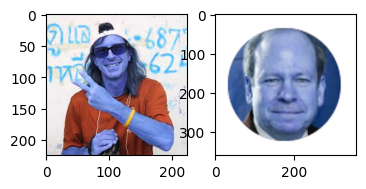

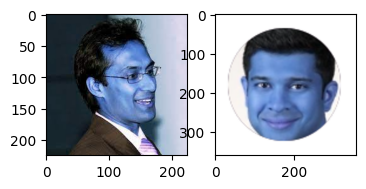

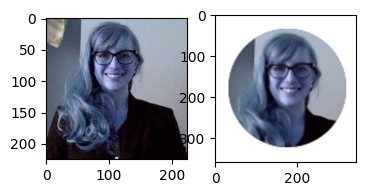

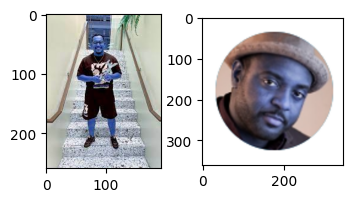

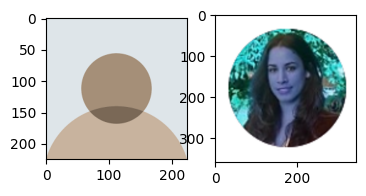

In [ ]:
is_null = np.random.choice(np.where(arcface['Prediction'].isnull())[0], size = 5)
for index in is_null:
  plt.figure(figsize=(4, 2))
  pair = (cv2.imread(arcface.loc[index, 'Path_Down']), cv2.imread(arcface.loc[index, 'Path_Screen']))
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

## ArcFace Law - Preparation

In [ ]:
download_folder = '/content/drive/MyDrive/downloaded_images_law'
down_images = os.listdir(download_folder)

download_data = pd.DataFrame()
download_paths = []
download_names = []

for i in tqdm(range(len(down_images))):
  download_paths.append(download_folder + '/' + down_images[i])
  download_names.append(down_images[i][:-14])

download_data['Path_Down'] = download_paths
download_data['Name'] = download_names

screenshots_folder = '/content/drive/MyDrive/Screenshots'
screenshots = os.listdir(screenshots_folder)

screenshots_data = pd.DataFrame()
screenshots_paths = []
screenshots_names = []

for i in tqdm(range(len(screenshots))):
  screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
  screenshots_names.append(screenshots[i][:-4])

screenshots_data['Path_Screen'] = screenshots_paths
screenshots_data['Name'] = screenshots_names

final_data = pd.merge(download_data, screenshots_data, on = 'Name')
print(final_data.shape)
final_data.head()

100%|██████████| 3758/3758 [00:00<00:00, 522445.95it/s]

(2593, 3)


,Path_Down,Name,Path_Screen
0,/content/drive/MyDrive/downloaded_images_law/I...,Ivory L. Bishop,/content/drive/MyDrive/Screenshots/Ivory L. Bi...
1,/content/drive/MyDrive/downloaded_images_law/J...,J. Benjamin Benjamin Aguinaga,/content/drive/MyDrive/Screenshots/J. Benjamin...
2,/content/drive/MyDrive/downloaded_images_law/J...,J. Brendan Day,/content/drive/MyDrive/Screenshots/J. Brendan ...
3,/content/drive/MyDrive/downloaded_images_law/J...,J. Brian Johns,/content/drive/MyDrive/Screenshots/J. Brian Jo...
4,/content/drive/MyDrive/downloaded_images_law/J...,J. Dillon Pitts,/content/drive/MyDrive/Screenshots/J. Dillon P...


In [ ]:
distances = []
predictions = []

for i in tqdm(range(len(final_data['Name']))):
  try:
    output = df.verify(cv2.imread(final_data.loc[i, 'Path_Down']), cv2.imread(final_data.loc[i, 'Path_Screen']), 'ArcFace')
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    predictions.append(None)
    distances.append(None)

final_data['Prediction'] = predictions
final_data['Distance'] = distances

#final_data.to_csv('/content/drive/MyDrive/ArcFace_Law_Accuracy.csv')

  0%|          | 1/2593 [00:00<28:49,  1.50it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  9%|▉         | 12.6M/137M [00:00<00:00, 126MB/s]
 20%|██        | 27.8M/137M [00:00<00:00, 137MB/s]
 31%|███       | 41.9M/137M [00:00<00:00, 124MB/s]
 44%|████▍     | 60.3M/137M [00:00<00:00, 145MB/s]
 55%|█████▍    | 75.0M/137M [00:00<00:00, 138MB/s]
 65%|██████▌   | 89.1M/137M [00:00<00:00, 125MB/s]
 75%|███████▍  | 102M/137M [00:00<00:00, 112MB/s] 
 83%|████████▎ | 114M/137M [00:00<00:00, 111MB/s]
100%|██████████| 137M/137M [00:01<00:00, 123MB/s]
100%|██████████| 2593/2593 [48:48<00:00,  1.13s/it]


## ArcFace Law - Results

In [ ]:
arc_law = pd.read_csv('/content/drive/MyDrive/ArcFace_Law_Accuracy.csv').drop('Unnamed: 0', axis = 1)
tot = arc_law.shape[0]
is_null = arc_law[arc_law['Prediction'].isnull()].shape[0]
not_null = arc_law[arc_law['Prediction'].notnull()].shape[0]
positive = arc_law[arc_law['Prediction'] == True].shape[0]
negative = arc_law[arc_law['Prediction'] == False].shape[0]

print('% of null comparisons: ', str(is_null*100/tot))
print('% of positive pairs: ', str(positive*100/not_null))
print('% of negative pairs: ', str(negative*100/not_null))

% of null comparisons:  6.980331662167374
% of positive pairs:  62.64510779436153
% of negative pairs:  37.35489220563847


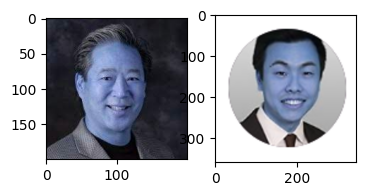

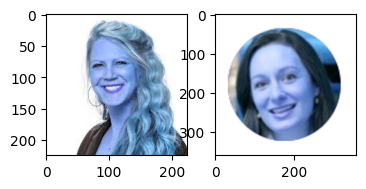

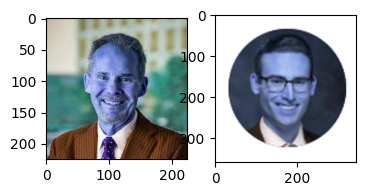

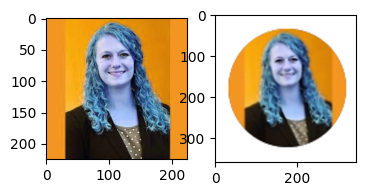

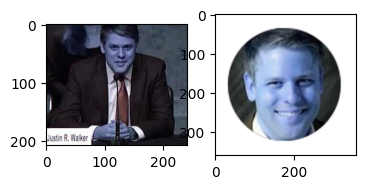

In [ ]:
negative = np.random.choice(np.where(arc_law['Prediction'] == False)[0], size = 5)
for index in negative:
  plt.figure(figsize=(4, 2))
  pair = (cv2.imread(arc_law.loc[index, 'Path_Down']), cv2.imread(arc_law.loc[index, 'Path_Screen']))
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

In [ ]:
origins_law = pd.read_csv('/content/drive/MyDrive/Images_Origins_Law.csv').drop('Unnamed: 0', axis = 1)

file_names = []
for i in range(arc_law.shape[0]):
  file_names.append(arc_law.loc[i, 'Path_Down'].split('/')[-1])

arc_law['File Name'] = file_names
final_law = pd.merge(arc_law, origins_law, on = 'File Name').drop('Name_y', axis = 1).rename({'Name_x':'Name'}, axis = 1)
final_law.head()

,Path_Down,Name,Path_Screen,Prediction,Distance,File Name,Origin
0,/content/drive/MyDrive/downloaded_images_law/I...,Ivory L. Bishop,/content/drive/MyDrive/Screenshots/Ivory L. Bi...,NaN,NaN,Ivory L. Bishop law firm0.jpg,Hofstra Law News - Hofstra University
1,/content/drive/MyDrive/downloaded_images_law/J...,J. Benjamin Benjamin Aguinaga,/content/drive/MyDrive/Screenshots/J. Benjamin...,True,0.333610,J. Benjamin Benjamin Aguinaga law firm0.jpg,Jones Day
2,/content/drive/MyDrive/downloaded_images_law/J...,J. Brendan Day,/content/drive/MyDrive/Screenshots/J. Brendan ...,False,0.760835,J. Brendan Day law firm0.jpg,Baker Botts
3,/content/drive/MyDrive/downloaded_images_law/J...,J. Brian Johns,/content/drive/MyDrive/Screenshots/J. Brian Jo...,True,0.431484,J. Brian Johns law firm0.jpg,LinkedIn
4,/content/drive/MyDrive/downloaded_images_law/J...,J. Dillon Pitts,/content/drive/MyDrive/Screenshots/J. Dillon P...,False,0.841059,J. Dillon Pitts law firm0.jpg,Clinton School of Public Service - University ...


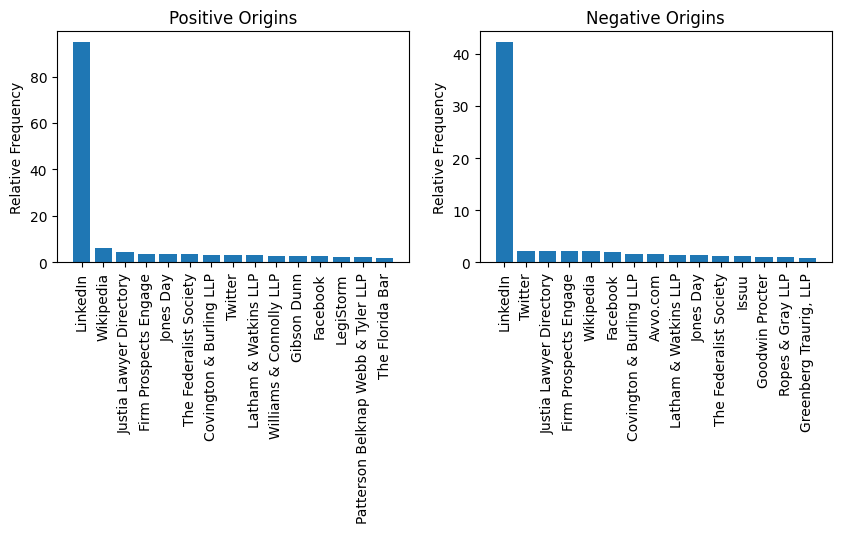

In [ ]:
origins_positive = final_law[final_law['Prediction'] == True]
counter = Counter(origins_positive['Origin'])
top_origins_pos = pd.DataFrame({'Origin': counter.keys(), 'Frequency': counter.values()})
top_origins_pos['Relative Frequency'] = top_origins_pos['Frequency']*100/top_origins_pos.shape[0]
top_origins_pos.sort_values('Frequency', ascending = False, inplace = True)
top_origins_pos = top_origins_pos.reset_index(drop = True)

origins_negative = final_law[final_law['Prediction'] == False]
counter = Counter(origins_negative['Origin'])
top_origins_neg = pd.DataFrame({'Origin': counter.keys(), 'Frequency': counter.values()})
top_origins_neg.sort_values('Frequency', ascending = False, inplace = True)
top_origins_neg['Relative Frequency'] = top_origins_neg['Frequency']*100/top_origins_neg.shape[0]
top_origins_neg = top_origins_neg.reset_index(drop = True)

plt.figure(figsize = (10,3))
plt.subplot(121)
plt.bar(top_origins_pos.loc[:14, 'Origin'], top_origins_pos.loc[:14, 'Relative Frequency'])
plt.xticks(rotation = 90)
plt.title('Positive Origins')
plt.ylabel('Relative Frequency')

plt.subplot(122)
plt.bar(top_origins_neg.loc[:14, 'Origin'], top_origins_neg.loc[:14, 'Relative Frequency'])
plt.xticks(rotation = 90)
plt.title('Negative Origins')
plt.ylabel('Relative Frequency')
plt.show()

## ArcFace LinkedIn + Title - Preparation

In [ ]:
screenshots_folder = '/content/drive/MyDrive/Screenshots'
screenshots = os.listdir(screenshots_folder)

screenshots_data = pd.DataFrame()
screenshots_paths = []
screenshots_names = []

for i in tqdm(range(len(screenshots))):
  screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
  screenshots_names.append(screenshots[i][:-4])

screenshots_data['Path_Screen'] = screenshots_paths
screenshots_data['Name'] = screenshots_names

print(screenshots_data.shape)
screenshots_data.head()

100%|██████████| 3758/3758 [00:00<00:00, 626378.73it/s]

(3758, 2)


,Path_Screen,Name
0,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes
1,/content/drive/MyDrive/Screenshots/Erik B. Kun...,Erik B. Kundu
2,/content/drive/MyDrive/Screenshots/Mason E. Re...,Mason E. Reynolds
3,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark
4,/content/drive/MyDrive/Screenshots/Eric Fisher...,Eric Fisher


In [ ]:
download_folder = '/content/drive/MyDrive/downloaded_images_title'
down_images = os.listdir(download_folder)

title_data = pd.DataFrame()
download_paths = []
download_names = []

for i in tqdm(range(len(down_images))):
  download_paths.append(download_folder + '/' + down_images[i])
  download_names.append(' '.join(down_images[i][:-13].split(' ')[:2]))

title_data['Path_Title'] = download_paths
title_data['Name'] = download_names

print(title_data.shape)
title_data.head()

100%|██████████| 969/969 [00:00<00:00, 345513.95it/s]

(969, 2)


,Path_Title,Name
0,/content/drive/MyDrive/downloaded_images_title...,Aaron Schuham
1,/content/drive/MyDrive/downloaded_images_title...,Aaron Washington
2,/content/drive/MyDrive/downloaded_images_title...,Aaron Zelinsky
3,/content/drive/MyDrive/downloaded_images_title...,Abbe Dembowitz
4,/content/drive/MyDrive/downloaded_images_title...,Abby Holland


In [ ]:
# ArcFace Model

final_data = pd.merge(screenshots_data, title_data, on = 'Name')

distances = []
predictions = []

for i in tqdm(range(len(final_data['Name']))):
  try:
    output = df.verify(cv2.imread(final_data.loc[i, 'Path_Title']), cv2.imread(final_data.loc[i, 'Path_Screen']), 'ArcFace')
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    predictions.append(None)
    distances.append(None)

final_data['Prediction'] = predictions
final_data['Distance'] = distances

  0%|          | 0/932 [00:00<?, ?it/s]Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5


arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5



  0%|          | 0.00/137M [00:00<?, ?B/s]
 21%|██        | 28.8M/137M [00:00<00:00, 287MB/s]
 46%|████▌     | 62.9M/137M [00:00<00:00, 318MB/s]
 72%|███████▏  | 98.0M/137M [00:00<00:00, 331MB/s]
100%|██████████| 137M/137M [00:00<00:00, 232MB/s]
100%|██████████| 932/932 [14:38<00:00,  1.06it/s]


In [ ]:
#final_data.to_csv('/content/drive/MyDrive/ArcFace_Title_Accuracy.csv')

## ArcFace LinkedIn vs Title - Results Comparison

In [ ]:
arcface_link = pd.read_csv('/content/drive/MyDrive/ArcFace_LinkedIn_Accuracy.csv').drop('Unnamed: 0', axis = 1)
arcface_title = pd.read_csv('/content/drive/MyDrive/ArcFace_Title_Accuracy.csv').drop('Unnamed: 0', axis = 1)
comparison = pd.merge(arcface_link, arcface_title, on = 'Name').rename({'Prediction_x':'Prediction_Link', 'Prediction_y':'Prediction_Title', 'Distance_x':'Distance_Link', 'Distance_y':'Distance:_Title'}, axis = 1)
comparison.head()

,Path_Down,Name,Path_Screen_x,Prediction_Link,Distance_Link,Path_Screen_y,Path_Title,Prediction_Title,Distance:_Title
0,/content/drive/MyDrive/downloaded_images/Megan...,Megan Lacy,/content/drive/MyDrive/Screenshots/Megan Lacy.png,NaN,NaN,/content/drive/MyDrive/Screenshots/Megan Lacy.png,/content/drive/MyDrive/downloaded_images_title...,False,0.954569
1,/content/drive/MyDrive/downloaded_images/Megan...,Megan Ong,/content/drive/MyDrive/Screenshots/Megan Ong.png,False,0.844280,/content/drive/MyDrive/Screenshots/Megan Ong.png,/content/drive/MyDrive/downloaded_images_title...,False,0.889077
2,/content/drive/MyDrive/downloaded_images/Melis...,Melissa Acevedo,/content/drive/MyDrive/Screenshots/Melissa Ace...,False,0.998744,/content/drive/MyDrive/Screenshots/Melissa Ace...,/content/drive/MyDrive/downloaded_images_title...,False,0.755280
3,/content/drive/MyDrive/downloaded_images/Melis...,Melissa Adams,/content/drive/MyDrive/Screenshots/Melissa Ada...,False,0.913761,/content/drive/MyDrive/Screenshots/Melissa Ada...,/content/drive/MyDrive/downloaded_images_title...,False,1.017645
4,/content/drive/MyDrive/downloaded_images/Melis...,Melissa Brown,/content/drive/MyDrive/Screenshots/Melissa Bro...,False,0.890047,/content/drive/MyDrive/Screenshots/Melissa Bro...,/content/drive/MyDrive/downloaded_images_title...,False,0.913194


In [ ]:
tot = comparison.shape[0]
tot_link = comparison[comparison['Prediction_Link'].notnull()].shape[0]
tot_title = comparison[comparison['Prediction_Title'].notnull()].shape[0]
pos_link = comparison[comparison['Prediction_Link'] == True].shape[0]
neg_link = comparison[comparison['Prediction_Link'] == False].shape[0]
null_link = comparison[comparison['Prediction_Link'].isnull()].shape[0]
pos_title =  comparison[comparison['Prediction_Title'] == True].shape[0]
neg_title = comparison[comparison['Prediction_Title'] == False].shape[0]
null_title = comparison[comparison['Prediction_Title'].isnull()].shape[0]

print('Positive LinkedIn: ', pos_link*100/tot_link)
print('Positive Title: ', pos_title*100/tot_title)
print('Negative LinkedIn: ', neg_link*100/tot_link)
print('Negative Title: ', neg_title*100/tot_title)
print('Null LinkedIn: ', null_link*100/tot)
print('Null Title: ', null_title*100/tot)

Positive LinkedIn:  35.364396654719236
Positive Title:  51.31578947368421
Negative LinkedIn:  64.63560334528077
Negative Title:  48.68421052631579
Null LinkedIn:  10.096670247046188
Null Title:  10.204081632653061


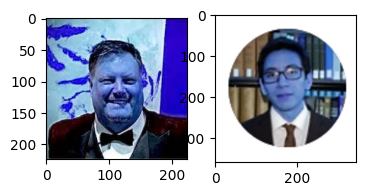

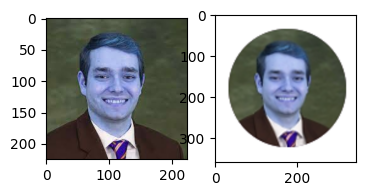

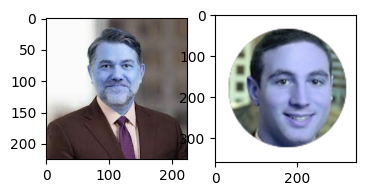

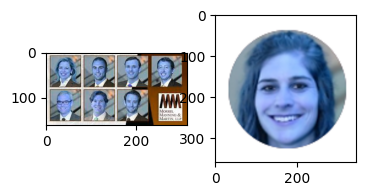

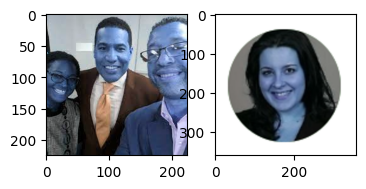

In [ ]:
negative = np.random.choice(np.where(arcface_title['Prediction'] == False)[0], size = 5)
for index in negative:
  plt.figure(figsize=(4, 2))
  pair = (cv2.imread(arcface_title.loc[index, 'Path_Title']), cv2.imread(arcface_title.loc[index, 'Path_Screen']))
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

## All Models Title - Preparation

In [ ]:
screenshots_folder = '/content/drive/MyDrive/Screenshots'
screenshots = os.listdir(screenshots_folder)

screenshots_data = pd.DataFrame()
screenshots_paths = []
screenshots_names = []

for i in tqdm(range(len(screenshots))):
  screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
  screenshots_names.append(screenshots[i][:-4])

screenshots_data['Path_Screen'] = screenshots_paths
screenshots_data['Name'] = screenshots_names

print(screenshots_data.shape)
screenshots_data.head()

In [ ]:
download_folder = '/content/drive/MyDrive/downloaded_images_title'
down_images = os.listdir(download_folder)

title_data = pd.DataFrame()
download_paths = []
download_names = []

for i in tqdm(range(len(down_images))):
  download_paths.append(download_folder + '/' + down_images[i])
  download_names.append(' '.join(down_images[i][:-13].split(' ')[:2]))

title_data['Path_Title'] = download_paths
title_data['Name'] = download_names

print(title_data.shape)
title_data.head()

In [ ]:
#All models

models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
all_models = pd.DataFrame()

for i in tqdm(range(len(models))):
  final_data = pd.merge(download_data, screenshots_data, on = 'Name')
  model = models[i]
  distances = []
  predictions = []
  for j in range(len(final_data['Name'])):
    try:
      output = df.verify(cv2.imread(final_data.loc[j, 'Path_Down']), cv2.imread(final_data.loc[j, 'Path_Screen']), 'ArcFace')
      predictions.append(output['verified'])
      distances.append(output['distance'])
    except:
      predictions.append(None)
      distances.append(None)

  final_data['Prediction'] = predictions
  final_data['Distance'] = distances
  final_data['Model'] = model
  all_models = pd.concat([all_models, final_data])

all_models.to_csv('/content/drive/MyDrive/All_Models_LinkedIn_Accuracy.csv')

 89%|████████▉ | 8/9 [4:32:54<33:47, 2027.24s/it]  

# Origins Comparison

## Preparation

In [ ]:
origins_data = pd.read_csv('/content/drive/MyDrive/Images_Origins.csv').drop('Unnamed: 0', axis = 1)
origins_data.head()

,Name,Origin,File Name
0,Aadika Singh,ACLU of Alaska,Aadika Singh0.jpg
1,Aadika Singh,RocketReach,Aadika Singh1.jpg
2,Aadika Singh,Behance,Aadika Singh2.jpg
3,Aadika Singh,Flickr,Aadika Singh3.jpg
4,Aadika Singh,LinkedIn,Aadika Singh4.jpg


In [ ]:
screenshots_folder = '/content/drive/MyDrive/Screenshots'
screenshots = os.listdir(screenshots_folder)

screenshots_data = pd.DataFrame()
screenshots_paths = []
screenshots_names = []

for i in tqdm(range(len(screenshots))):
  screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
  screenshots_names.append(screenshots[i][:-4])

screenshots_data['Path_Screen'] = screenshots_paths
screenshots_data['Name'] = screenshots_names

print(screenshots_data.shape)
screenshots_data.head()

100%|██████████| 3758/3758 [00:00<00:00, 328406.42it/s]

(3758, 2)


,Path_Screen,Name
0,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes
1,/content/drive/MyDrive/Screenshots/Erik B. Kun...,Erik B. Kundu
2,/content/drive/MyDrive/Screenshots/Mason E. Re...,Mason E. Reynolds
3,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark
4,/content/drive/MyDrive/Screenshots/Eric Fisher...,Eric Fisher


In [ ]:
download_folder = '/content/drive/MyDrive/downloaded_images_multiple'
down_images = os.listdir(download_folder)

names_data = pd.DataFrame()
download_paths = []
download_names = []
file_names = []

for i in tqdm(range(len(down_images))):
  download_paths.append(download_folder + '/' + down_images[i])
  download_names.append(down_images[i][:-5])
  file_names.append(down_images[i])

names_data['Path_Down'] = download_paths
names_data['Name'] = download_names
names_data['File Name'] = file_names

print(names_data.shape)
names_data.head()

100%|██████████| 18746/18746 [00:00<00:00, 626171.07it/s]

(18746, 3)


,Path_Down,Name,File Name
0,/content/drive/MyDrive/downloaded_images_multi...,Taylor Davidson,Taylor Davidson2.jpg
1,/content/drive/MyDrive/downloaded_images_multi...,Taylor Davidson,Taylor Davidson0.jpg
2,/content/drive/MyDrive/downloaded_images_multi...,Taylor Davidson,Taylor Davidson4.jpg
3,/content/drive/MyDrive/downloaded_images_multi...,Taylor Davidson,Taylor Davidson1.jpg
4,/content/drive/MyDrive/downloaded_images_multi...,Taylor Davidson,Taylor Davidson3.jpg


In [ ]:
names_origins = pd.merge(names_data, origins_data, on = ['Name', 'File Name'])
final_data = pd.merge(screenshots_data, names_origins, on = 'Name')
print(final_data.shape)
final_data.head()

(18736, 5)


,Path_Screen,Name,Path_Down,File Name,Origin
0,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes3.jpg,Diaz Reus
1,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes2.jpg,Firm Prospects Engage
2,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes4.jpg,Twitter
3,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes1.jpg,LinkedIn
4,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes0.jpg,Rattler Nation


In [ ]:
distances = []
predictions = []

for i in tqdm(range(len(final_data['Name']))):
  try:
    output = df.verify(cv2.imread(final_data.loc[i, 'Path_Down']), cv2.imread(final_data.loc[i, 'Path_Screen']), 'ArcFace')
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    predictions.append(None)
    distances.append(None)

final_data['Prediction'] = predictions
final_data['Distance'] = distances

#final_data.to_csv('/content/drive/MyDrive/Origins_Accuracy.csv')

  0%|          | 0/18736 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  5%|▍         | 6.29M/137M [00:00<00:02, 61.6MB/s]
  9%|▉         | 12.6M/137M [00:00<00:02, 50.1MB/s]
 14%|█▍        | 19.4M/137M [00:00<00:02, 56.7MB/s]
 19%|█▊        | 25.7M/137M [00:00<00:02, 51.2MB/s]
 24%|██▎       | 32.5M/137M [00:00<00:01, 56.0MB/s]
 28%|██▊       | 38.3M/137M [00:00<00:01, 50.4MB/s]
 33%|███▎      | 45.1M/137M [00:00<00:01, 53.4MB/s]
 37%|███▋      | 50.9M/137M [00:00<00:01, 52.2MB/s]
 42%|████▏     | 57.1M/137M [00:01<00:01, 54.8MB/s]
 47%|████▋     | 64.5M/137M [00:01<00:01, 53.3MB/s]
 52%|█████▏    | 71.3M/137M [00:01<00:01, 56.6MB/s]
 57%|█████▋    | 78.1M/137M [00:01<00:01, 53.7MB/s]
 62%|██████▏   | 84.9M/137M [00:01<00:00, 57.1MB/s]
 67%|██████▋   | 91.8M/137M [00:01<00:00, 54.2MB/s]
 72%|███████▏  | 98.6M/137M [00:01<00:00, 57.5MB/s]
 77%|███████▋  | 105M/

## Results

In [ ]:
origins = pd.read_csv('/content/drive/MyDrive/Origins_Accuracy.csv').drop('Unnamed: 0', axis = 1)
origins['Prediction'] = origins['Prediction']*1

names = np.array(origins['Name'])
indexes = [i for i in range(len(names)) if 'no_photo' in names[i]]
origins = origins.drop(indexes).reset_index(drop = True)
origins['Prediction'] = origins['Prediction'].astype('float32')

print(origins.shape)
origins.head()

(18556, 7)


,Path_Screen,Name,Path_Down,File Name,Origin,Prediction,Distance
0,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes3.jpg,Diaz Reus,1.0,0.604889
1,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes2.jpg,Firm Prospects Engage,1.0,0.588676
2,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes4.jpg,Twitter,1.0,0.618315
3,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes1.jpg,LinkedIn,1.0,0.528078
4,/content/drive/MyDrive/Screenshots/Ta_Ronce St...,Ta_Ronce Stowes,/content/drive/MyDrive/downloaded_images_multi...,Ta_Ronce Stowes0.jpg,Rattler Nation,1.0,0.472182


In [ ]:
origins_aggregate = origins.groupby('Name').sum()
tot = origins_aggregate.shape[0]
is_null = origins_aggregate[origins_aggregate['Prediction'].isnull()].shape[0]
not_null = origins_aggregate[origins_aggregate['Prediction'].notnull()].shape[0]
positive = origins_aggregate[origins_aggregate['Prediction'] > 0].shape[0]
negative = origins_aggregate[origins_aggregate['Prediction'] == 0].shape[0]

print('% of null comparisons: ', str(is_null*100/tot))
print('% of positive pairs: ', str(positive*100/not_null))
print('% of negative pairs: ', str(negative*100/not_null))

% of null comparisons:  0.0
% of positive pairs:  58.83620689655172
% of negative pairs:  41.16379310344828


In [ ]:
origins_positive = origins[origins['Prediction'] == 1]
counter = Counter(origins_positive['Origin'])
top_origins_pos = pd.DataFrame({'Origin': counter.keys(), 'Frequency': counter.values()})
top_origins_pos['Relative Frequency'] = top_origins_pos['Frequency']*100/top_origins_pos.shape[0]
top_origins_pos.sort_values('Frequency', ascending = False, inplace = True)
top_origins_pos = top_origins_pos.reset_index(drop = True)
top_origins_pos.head()

,Origin,Frequency,Relative Frequency
0,LinkedIn,833,53.603604
1,Twitter,251,16.151866
2,Facebook,132,8.494208
3,Wikipedia,110,7.078507
4,Firm Prospects Engage,101,6.499356


In [ ]:
origins_negative = origins[origins['Prediction'] == 0]
counter = Counter(origins_negative['Origin'])
top_origins_neg = pd.DataFrame({'Origin': counter.keys(), 'Frequency': counter.values()})
top_origins_neg.sort_values('Frequency', ascending = False, inplace = True)
top_origins_neg['Relative Frequency'] = top_origins_neg['Frequency']*100/top_origins_neg.shape[0]
top_origins_neg = top_origins_neg.reset_index(drop = True)
top_origins_neg.head()

,Origin,Frequency,Relative Frequency
0,LinkedIn,1602,44.848824
1,Twitter,516,14.445689
2,Facebook,326,9.126540
3,Wikipedia,284,7.950728
4,IMDb,188,5.263158


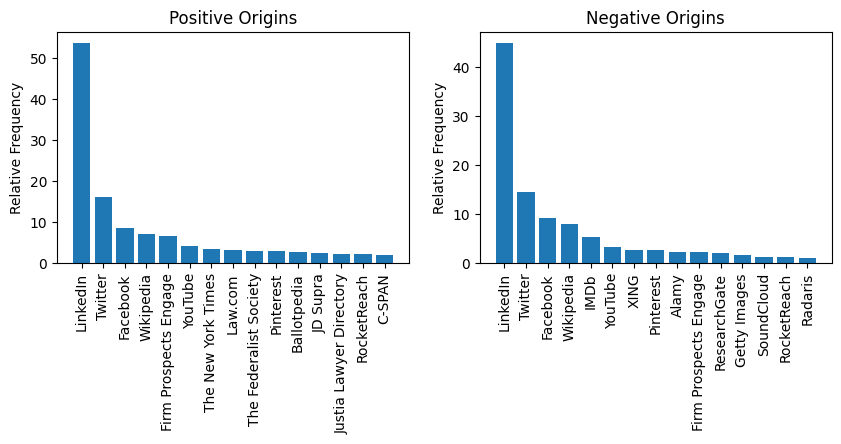

In [ ]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.bar(top_origins_pos.loc[:14, 'Origin'], top_origins_pos.loc[:14, 'Relative Frequency'])
plt.xticks(rotation = 90)
plt.title('Positive Origins')
plt.ylabel('Relative Frequency')

plt.subplot(122)
plt.bar(top_origins_neg.loc[:14, 'Origin'], top_origins_neg.loc[:14, 'Relative Frequency'])
plt.xticks(rotation = 90)
plt.title('Negative Origins')
plt.ylabel('Relative Frequency')
plt.show()

In [ ]:
top_comparison = pd.merge(top_origins_pos, top_origins_neg, on = 'Origin')
top_comparison['Absolute Difference'] = top_comparison['Frequency_x'] - top_comparison['Frequency_y']
top_comparison['Relative Difference'] = top_comparison['Relative Frequency_x'] - top_comparison['Relative Frequency_y']
top_comparison = top_comparison.sort_values('Relative Difference', ascending = False)
top_comparison.head()

NameError: ignored

# 5 Images Comparisons

## Files Preparation

In [ ]:
def images_comparison(download_folder, ub, file_name):
  screenshots_folder = '/content/drive/MyDrive/Screenshots'
  screenshots = os.listdir(screenshots_folder)

  screenshots_data = pd.DataFrame()
  screenshots_paths = []
  screenshots_names = []

  for i in range(len(screenshots)):
    screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
    screenshots_names.append(screenshots[i][:-4])

  screenshots_data['Path_Screen'] = screenshots_paths
  screenshots_data['Name'] = screenshots_names

  down_images = os.listdir(download_folder)

  names_data = pd.DataFrame()
  download_paths = []
  download_names = []
  file_names = []

  for i in range(len(down_images)):
    download_paths.append(download_folder + '/' + down_images[i])
    download_names.append(down_images[i][:-ub])
    file_names.append(down_images[i])

  names_data['Path_Down'] = download_paths
  names_data['Name'] = download_names
  names_data['File Name'] = file_names

  final_data = pd.merge(screenshots_data, names_data, on = 'Name')

  distances = []
  predictions = []

  for i in tqdm(range(len(final_data['Name']))):
    try:
      output = df.verify(cv2.imread(final_data.loc[i, 'Path_Down']), cv2.imread(final_data.loc[i, 'Path_Screen']), 'ArcFace')
      predictions.append(output['verified'])
      distances.append(output['distance'])
    except:
      predictions.append(None)
      distances.append(None)

  final_data['Prediction'] = predictions
  final_data['Distance'] = distances

  file_path = '/content/drive/MyDrive/' + file_name + '.csv'
  final_data.to_csv(file_path)

In [ ]:
def images_comparison_2(download_folder, file_name):
  screenshots_folder = '/content/drive/MyDrive/Screenshots'
  screenshots = os.listdir(screenshots_folder)

  screenshots_data = pd.DataFrame()
  screenshots_paths = []
  screenshots_names = []

  for i in range(len(screenshots)):
    screenshots_paths.append(screenshots_folder + '/' + screenshots[i])
    screenshots_names.append(screenshots[i][:-4])

  screenshots_data['Path_Screen'] = screenshots_paths
  screenshots_data['Name'] = screenshots_names

  down_images = os.listdir(download_folder)

  names_data = pd.DataFrame()
  download_paths = []
  download_names = []
  file_names = []

  for i in range(len(down_images)):
    download_paths.append(download_folder + '/' + down_images[i])
    name_components = down_images[i].split(' ')
    image_name = ''
    for j in range(len(name_components)):
      if name_components[j] != 'LinkedIn':
        image_name = image_name + ' ' + name_components[j]
      else:
        break

    download_names.append(image_name[1:])
    file_names.append(down_images[i])

  names_data['Path_Down'] = download_paths
  names_data['Name'] = download_names
  names_data['File Name'] = file_names

  final_data = pd.merge(screenshots_data, names_data, on = 'Name')

  distances = []
  predictions = []

  for i in tqdm(range(len(final_data['Name']))):
    try:
      output = df.verify(cv2.imread(final_data.loc[i, 'Path_Down']), cv2.imread(final_data.loc[i, 'Path_Screen']), 'ArcFace')
      predictions.append(output['verified'])
      distances.append(output['distance'])
    except:
      predictions.append(None)
      distances.append(None)

  final_data['Prediction'] = predictions
  final_data['Distance'] = distances

  file_path = '/content/drive/MyDrive/' + file_name + '.csv'
  final_data.to_csv(file_path)

In [ ]:
images_comparison('/content/drive/MyDrive/LinkedIn_5', 15, 'LinkedIn_5_Comparison')

100%|██████████| 2290/2290 [35:20<00:00,  1.08it/s]


In [ ]:
images_comparison('/content/drive/MyDrive/Linkedin_Law_5', 19, 'LinkedIn_Law_5_Comparison')

100%|██████████| 1655/1655 [14:28<00:00,  1.91it/s]


In [ ]:
images_comparison_2('/content/drive/MyDrive/LinkedIn_Title_5', 'LinkedIn_Title_5_Comparison')

100%|██████████| 1680/1680 [25:14<00:00,  1.11it/s]


In [ ]:
images_comparison('/content/drive/MyDrive/Standard_10', 6, 'Standard_10_Comparison')

  0%|          | 0/4983 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  1%|          | 1.05M/137M [00:00<00:17, 7.95MB/s]
  2%|▏         | 3.15M/137M [00:00<00:10, 13.3MB/s]
  5%|▍         | 6.29M/137M [00:00<00:06, 19.4MB/s]
  8%|▊         | 10.5M/137M [00:00<00:04, 26.9MB/s]
 12%|█▏        | 16.3M/137M [00:00<00:03, 36.9MB/s]
 18%|█▊        | 25.2M/137M [00:00<00:02, 52.7MB/s]
 27%|██▋       | 37.2M/137M [00:00<00:01, 73.5MB/s]
 39%|███▉      | 54.0M/137M [00:00<00:00, 101MB/s] 
 55%|█████▌    | 75.5M/137M [00:00<00:00, 135MB/s]
 70%|███████   | 95.9M/137M [00:01<00:00, 156MB/s]
 82%|████████▏ | 112M/137M [00:01<00:00, 151MB/s] 
100%|██████████| 137M/137M [00:01<00:00, 101MB/s]
100%|██████████| 4983/4983 [53:57<00:00,  1.54it/s]


In [ ]:
images_comparison('/content/drive/MyDrive/LinkedIn_10', 15, 'LinkedIn_10_Comparison')

100%|██████████| 4990/4990 [56:07<00:00,  1.48it/s]


In [ ]:
images_comparison('/content/drive/MyDrive/LinkedIn_Law_10', 19, 'LinkedIn_Law_10_Comparison')

100%|██████████| 4990/4990 [59:11<00:00,  1.41it/s]


In [ ]:
images_comparison_2('/content/drive/MyDrive/LinkedIn_Title_10', 'LinkedIn_Title_10_Comparison')

  0%|          | 0/5248 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  1%|          | 1.57M/137M [00:00<00:11, 11.7MB/s]
  3%|▎         | 3.67M/137M [00:00<00:08, 15.8MB/s]
  5%|▍         | 6.82M/137M [00:00<00:05, 21.8MB/s]
  8%|▊         | 11.5M/137M [00:00<00:04, 30.8MB/s]
 13%|█▎        | 18.4M/137M [00:00<00:02, 43.2MB/s]
 21%|██        | 28.8M/137M [00:00<00:01, 62.7MB/s]
 33%|███▎      | 45.1M/137M [00:00<00:00, 94.1MB/s]
 50%|████▉     | 68.2M/137M [00:00<00:00, 136MB/s] 
 68%|██████▊   | 93.3M/137M [00:00<00:00, 171MB/s]
100%|██████████| 137M/137M [00:01<00:00, 119MB/s]
100%|██████████| 5248/5248 [37:03<00:00,  2.36it/s]


## Results

In [5]:
linkedin = pd.read_csv('/content/drive/MyDrive/LinkedIn_5_Comparison.csv').drop('Unnamed: 0', axis = 1)
linkedin_law = pd.read_csv('/content/drive/MyDrive/LinkedIn_Law_5_Comparison.csv').drop('Unnamed: 0', axis = 1)
linkedin_title = pd.read_csv('/content/drive/MyDrive/LinkedIn_Title_5_Comparison.csv').drop('Unnamed: 0', axis = 1)
standard = pd.read_csv('/content/drive/MyDrive/Origins_Accuracy.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
linkedin.head()

,Path_Screen,Name,Path_Down,File Name,Prediction,Distance
0,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark,/content/drive/MyDrive/LinkedIn_5/Harrison Sta...,Harrison Stark LinkedIn_3.jpg,False,0.945168
1,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark,/content/drive/MyDrive/LinkedIn_5/Harrison Sta...,Harrison Stark LinkedIn_0.jpg,False,0.984574
2,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark,/content/drive/MyDrive/LinkedIn_5/Harrison Sta...,Harrison Stark LinkedIn_2.jpg,False,0.866421
3,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark,/content/drive/MyDrive/LinkedIn_5/Harrison Sta...,Harrison Stark LinkedIn_1.jpg,False,0.932704
4,/content/drive/MyDrive/Screenshots/Harrison St...,Harrison Stark,/content/drive/MyDrive/LinkedIn_5/Harrison Sta...,Harrison Stark LinkedIn_4.jpg,False,0.978700


In [13]:
def match_rates(data_set):
    data_set.loc[:, 'Label Prediction'] = data_set.apply(lambda x: 1 if x['Prediction'] is True else 0, axis = 1)
    dataset_aggregate = data_set.groupby('Name').sum(numeric_only = True)
    tot = dataset_aggregate.shape[0]
    is_null = dataset_aggregate[dataset_aggregate['Label Prediction'].isnull()].shape[0]
    not_null = dataset_aggregate[dataset_aggregate['Label Prediction'].notnull()].shape[0]
    positive = dataset_aggregate[dataset_aggregate['Label Prediction'] > 0].shape[0]
    negative = dataset_aggregate[dataset_aggregate['Label Prediction'] == 0].shape[0]

    print('% of null comparisons: ', str(is_null*100/tot))
    print('% of positive pairs: ', str(positive*100/not_null))
    print('% of negative pairs: ', str(negative*100/not_null))


    dataset_positive = dataset_aggregate[dataset_aggregate['Label Prediction'] > 0]
    print('Average Prediction: ', int(dataset_positive['Label Prediction'].sum())/dataset_positive.shape[0])

    try:
      data_set.loc[:, 'First'] = data_set.apply(lambda x: 1 if x['File Name'].split('_')[1][0] == str(0) else 0, axis = 1)
    except:
      data_set.loc[:, 'First'] = data_set.apply(lambda x: 1 if x['File Name'].split('.')[0][-1] == str(0) else 0, axis = 1)
    dataset_first = data_set[data_set['First'] == 1]
    print('Percentage of first predictions: ', dataset_first['Label Prediction'].mean()*100)

In [4]:
def match_rates_2(data_set):
    data_set.loc[:, 'Label Prediction'] = data_set.apply(lambda x: 1 if x['Prediction'] is True else 0, axis = 1)
    dataset_aggregate = data_set.groupby('Name').sum(numeric_only = True)
    tot = dataset_aggregate.shape[0]
    is_null = dataset_aggregate.loc[dataset_aggregate['Label Prediction'].isnull(), :].shape[0]
    not_null = dataset_aggregate.loc[dataset_aggregate['Label Prediction'].notnull(), :].shape[0]
    positive = dataset_aggregate.loc[dataset_aggregate['Label Prediction'] > 0, :].shape[0]
    negative = dataset_aggregate.loc[dataset_aggregate['Label Prediction'] == 0, :].shape[0]

    print('% of null comparisons: ', str(is_null*100/tot))
    print('% of positive pairs: ', str(positive*100/not_null))
    print('% of negative pairs: ', str(negative*100/not_null))

    dataset_positive = dataset_aggregate.loc[dataset_aggregate['Label Prediction'] > 0, :]
    print('Average Prediction: ', int(dataset_positive['Label Prediction'].sum())/dataset_positive.shape[0])

    data_set.loc[:, 'First'] = data_set.apply(lambda x: 1 if x['File Name'].split('.')[0][-1] == str(0) else 0, axis = 1)
    dataset_first = data_set.loc[data_set['First'] == 1, :]
    print('Percentage of first predictions: ', dataset_first['Label Prediction'].mean()*100)

In [14]:
match_rates(standard)

% of null comparisons:  0.0
% of positive pairs:  58.27107790821771
% of negative pairs:  41.72892209178229
Average Prediction:  2.21474358974359
Percentage of first predictions:  40.682502509200404


In [9]:
match_rates(linkedin)

% of null comparisons:  0.0
% of positive pairs:  57.4235807860262
% of negative pairs:  42.5764192139738
Average Prediction:  1.403041825095057
Percentage of first predictions:  38.681318681318686


In [ ]:
match_rates(linkedin_law)

% of null comparisons:  0.0
% of positive pairs:  66.46525679758308
% of negative pairs:  33.53474320241692
Average Prediction:  1.7045454545454546
Percentage of first predictions:  55.35168195718655


In [ ]:
match_rates(linkedin_title)

% of null comparisons:  0.0
% of positive pairs:  57.99373040752351
% of negative pairs:  42.00626959247649
Average Prediction:  1.7243243243243243
Percentage of first predictions:  45.23809523809524


In [11]:
linkedin_10 = pd.read_csv('/content/drive/MyDrive/LinkedIn_10_Comparison.csv').drop('Unnamed: 0', axis = 1)
linkedin_law_10 = pd.read_csv('/content/drive/MyDrive/LinkedIn_Law_10_Comparison.csv').drop('Unnamed: 0', axis = 1)
linkedin_title_10 = pd.read_csv('/content/drive/MyDrive/LinkedIn_Title_10_Comparison.csv').drop('Unnamed: 0', axis = 1)
standard_10 = pd.read_csv('/content/drive/MyDrive/Standard_10_Comparison.csv').drop('Unnamed: 0', axis = 1)

In [12]:
match_rates(standard_10)
match_rates(linkedin_10)
match_rates(linkedin_law_10)
match_rates(linkedin_title_10)

% of null comparisons:  0.0
% of positive pairs:  67.53507014028057
% of negative pairs:  32.46492985971944
Average Prediction:  2.6320474777448073
Percentage of first predictions:  43.54838709677419
% of null comparisons:  0.0
% of positive pairs:  63.52705410821643
% of negative pairs:  36.47294589178357
Average Prediction:  1.5205047318611988
Percentage of first predictions:  36.49193548387097
% of null comparisons:  0.0
% of positive pairs:  70.94188376753507
% of negative pairs:  29.05811623246493
Average Prediction:  1.7937853107344632
Percentage of first predictions:  54.76673427991886
% of null comparisons:  0.0
% of positive pairs:  60.53169734151329
% of negative pairs:  39.46830265848671
Average Prediction:  2.070945945945946
Percentage of first predictions:  43.80952380952381


## Majority Voting

In [ ]:
download_folder = '/content/drive/MyDrive/LinkedIn_5'
down_images = os.listdir(download_folder)
names_data = pd.DataFrame()
download_paths = []
download_names = []
file_names = []

for i in range(len(down_images)):
  download_paths.append(download_folder + '/' + down_images[i])
  download_names.append(down_images[i][:-15])
  file_names.append(down_images[i])

names_data['Path_Down'] = download_paths
names_data['Name'] = download_names
names_data['File Name'] = file_names
names_data.head()

,Path_Down,Name,File Name
0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg
1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_3.jpg
2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_1.jpg
3,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_2.jpg
4,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_4.jpg


In [ ]:
problematic_names = []
files_names = list(names_data['File Name'])
for i in range(len(files_names)):
  try:
    int(files_names[i].split('_')[1][0])
  except:
    #print(files_names[i])
    problematic_names.append(files_names[i])
names_data = names_data[~names_data['File Name'].isin(problematic_names)]

In [ ]:
#Sample Trial
sub_names_data = names_data.loc[:4, :]
sub_names_data['Name_Index'] = sub_names_data.apply(lambda x: int(x['File Name'].split('_')[1][0]), axis = 1)
combinations = pd.merge(sub_names_data, sub_names_data, on = 'Name', how = 'right')
combinations = combinations[combinations['Name_Index_x'] < combinations['Name_Index_y']].reset_index(drop = True)
print(combinations.shape[0])
combinations.head()

10


,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y
0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3
1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_1.jpg,1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3
2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_2.jpg,2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3
3,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_1.jpg,1
4,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_2.jpg,2


In [ ]:
names_data['Name_Index'] = names_data.apply(lambda x: int(x['File Name'].split('_')[1][0]), axis = 1)
combinations = pd.merge(names_data, names_data, on = 'Name', how = 'right')
combinations = combinations[combinations['Name_Index_x'] < combinations['Name_Index_y']].reset_index(drop = True)
print(combinations.shape[0])
combinations.head()

4550


,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y
0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3
1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_1.jpg,1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3
2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_2.jpg,2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3
3,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_1.jpg,1
4,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_2.jpg,2


In [ ]:
distances = []
predictions = []

for i in tqdm(range(combinations.shape[0])):
  try:
    output = df.verify(cv2.imread(combinations.loc[i, 'Path_Down_x']), cv2.imread(combinations.loc[i, 'Path_Down_y']), 'ArcFace')
    predictions.append(output['verified'])
    distances.append(output['distance'])
  except:
    predictions.append(None)
    distances.append(None)

combinations['Prediction'] = predictions
combinations['Distance'] = distances
combinations.to_csv('/content/drive/MyDrive/LinkedIn_5_Combinations.csv')
combinations.head()

  0%|          | 0/4550 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  1%|          | 1.05M/137M [00:00<00:18, 7.33MB/s]
  2%|▏         | 2.62M/137M [00:00<00:12, 10.5MB/s]
  3%|▎         | 4.72M/137M [00:00<00:09, 14.6MB/s]
  6%|▌         | 8.39M/137M [00:00<00:05, 21.6MB/s]
 10%|▉         | 13.6M/137M [00:00<00:03, 31.5MB/s]
 16%|█▌        | 22.0M/137M [00:00<00:02, 47.7MB/s]
 25%|██▌       | 34.6M/137M [00:00<00:01, 71.4MB/s]
 39%|███▊      | 53.0M/137M [00:00<00:00, 105MB/s] 
 57%|█████▋    | 78.1M/137M [00:00<00:00, 149MB/s]
 75%|███████▍  | 102M/137M [00:01<00:00, 177MB/s] 
100%|██████████| 137M/137M [00:01<00:00, 110MB/s]
100%|██████████| 4550/4550 [52:41<00:00,  1.44it/s]


,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y,Prediction,Distance
0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3,False,0.839820
1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_1.jpg,1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3,False,0.858837
2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_2.jpg,2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3,False,0.801979
3,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_1.jpg,1,False,0.881350
4,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_2.jpg,2,False,0.887185


In [ ]:
def combinations(download_folder, final_name):
  down_images = os.listdir(download_folder)
  names_data = pd.DataFrame()
  download_paths = []
  download_names = []
  file_names = []

  for i in range(len(down_images)):
    download_paths.append(download_folder + '/' + down_images[i])
    name_components = down_images[i].split(' ')
    image_name = ''
    for j in range(len(name_components)):
      if name_components[j] != 'LinkedIn':
        image_name = image_name + ' ' + name_components[j]
      else:
        break

    download_names.append(image_name[1:])
    file_names.append(down_images[i])

  names_data['Path_Down'] = download_paths
  names_data['Name'] = download_names
  names_data['File Name'] = file_names

  problematic_names = []
  files_names = list(names_data['File Name'])
  for i in range(len(files_names)):
    try:
      int(files_names[i].split('_')[1][0])
    except:
      problematic_names.append(files_names[i])

  names_data = names_data[~names_data['File Name'].isin(problematic_names)]

  names_data['Name_Index'] = names_data.apply(lambda x: int(x['File Name'].split('_')[1][0]), axis = 1)
  combinations = pd.merge(names_data, names_data, on = 'Name', how = 'right')
  combinations = combinations[combinations['Name_Index_x'] < combinations['Name_Index_y']].reset_index(drop = True)

  distances = []
  predictions = []

  for i in tqdm(range(combinations.shape[0])):
    try:
      output = df.verify(cv2.imread(combinations.loc[i, 'Path_Down_x']), cv2.imread(combinations.loc[i, 'Path_Down_y']), 'ArcFace')
      predictions.append(output['verified'])
      distances.append(output['distance'])
    except:
      predictions.append(None)
      distances.append(None)

  combinations['Prediction'] = predictions
  combinations['Distance'] = distances

  final_path = '/content/drive/MyDrive/' + final_name + '.csv'
  combinations.to_csv(final_path)

In [ ]:
combinations('/content/drive/MyDrive/Linkedin_Law_5', 'LinkedIn_Law_5_Combinations')

  0%|          | 0/3270 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  1%|          | 1.05M/137M [00:00<00:15, 8.57MB/s]
  2%|▏         | 3.15M/137M [00:00<00:09, 14.3MB/s]
  5%|▍         | 6.82M/137M [00:00<00:05, 22.6MB/s]
 10%|▉         | 13.1M/137M [00:00<00:03, 37.0MB/s]
 16%|█▌        | 21.5M/137M [00:00<00:02, 52.8MB/s]
 28%|██▊       | 38.8M/137M [00:00<00:01, 91.4MB/s]
 42%|████▏     | 57.7M/137M [00:00<00:00, 120MB/s] 
 51%|█████▏    | 70.3M/137M [00:00<00:00, 103MB/s]
 59%|█████▉    | 81.3M/137M [00:01<00:00, 91.2MB/s]
 67%|██████▋   | 91.2M/137M [00:01<00:00, 83.7MB/s]
 73%|███████▎  | 100M/137M [00:01<00:00, 83.6MB/s] 
 80%|███████▉  | 109M/137M [00:01<00:00, 80.4MB/s]
 86%|████████▌ | 117M/137M [00:01<00:00, 79.1MB/s]
 92%|█████████▏| 126M/137M [00:01<00:00, 77.8MB/s]
100%|██████████| 137M/137M [00:01<00:00, 74.9MB/s]
100%|██████████| 3270/3270 

,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y,Prediction,Distance
0,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet,Sarah Lipton-Lubet LinkedIn Law_0.jpg,0,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet LinkedIn Law_2.jpg,2,True,0.658933
1,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet,Sarah Lipton-Lubet LinkedIn Law_1.jpg,1,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet LinkedIn Law_2.jpg,2,True,0.627564
2,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet,Sarah Lipton-Lubet LinkedIn Law_2.jpg,2,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet LinkedIn Law_4.jpg,4,True,0.611889
3,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet,Sarah Lipton-Lubet LinkedIn Law_0.jpg,0,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet LinkedIn Law_4.jpg,4,True,0.648866
4,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet,Sarah Lipton-Lubet LinkedIn Law_1.jpg,1,/content/drive/MyDrive/Linkedin_Law_5/Sarah Li...,Sarah Lipton-Lubet LinkedIn Law_4.jpg,4,True,0.497997
...,...,...,...,...,...,...,...,...,...
3265,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko,Carrie L. (Miller) Chelko LinkedIn Law_0.jpg,0,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko LinkedIn Law_1.jpg,1,False,0.946798
3266,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko,Carrie L. (Miller) Chelko LinkedIn Law_3.jpg,3,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko LinkedIn Law_4.jpg,4,False,0.868305
3267,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko,Carrie L. (Miller) Chelko LinkedIn Law_2.jpg,2,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko LinkedIn Law_4.jpg,4,False,1.038401
3268,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko,Carrie L. (Miller) Chelko LinkedIn Law_0.jpg,0,/content/drive/MyDrive/Linkedin_Law_5/Carrie L...,Carrie L. (Miller) Chelko LinkedIn Law_4.jpg,4,False,0.889883


In [ ]:
combinations('/content/drive/MyDrive/LinkedIn_Title_5', 'LinkedIn_Title_5_Combinations')

100%|██████████| 3800/3800 [37:52<00:00,  1.67it/s]


,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y,Prediction,Distance
0,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross,Bertrall L. Ross LinkedIn Member_0.jpg,0,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross LinkedIn Member_1.jpg,1,True,0.245978
1,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross,Bertrall L. Ross LinkedIn Member_0.jpg,0,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross LinkedIn Member_4.jpg,4,True,0.255766
2,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross,Bertrall L. Ross LinkedIn Member_1.jpg,1,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross LinkedIn Member_4.jpg,4,True,0.098555
3,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross,Bertrall L. Ross LinkedIn Member_3.jpg,3,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross LinkedIn Member_4.jpg,4,False,0.771217
4,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross,Bertrall L. Ross LinkedIn Member_2.jpg,2,/content/drive/MyDrive/LinkedIn_Title_5/Bertra...,Bertrall L. Ross LinkedIn Member_4.jpg,4,True,0.064809
...,...,...,...,...,...,...,...,...,...
3795,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers,Dante Chambers LinkedIn Law Clerk_0.jpg,0,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers LinkedIn Law Clerk_1.jpg,1,None,NaN
3796,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers,Dante Chambers LinkedIn Law Clerk_3.jpg,3,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers LinkedIn Law Clerk_4.jpg,4,False,1.038723
3797,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers,Dante Chambers LinkedIn Law Clerk_2.jpg,2,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers LinkedIn Law Clerk_4.jpg,4,False,0.901504
3798,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers,Dante Chambers LinkedIn Law Clerk_0.jpg,0,/content/drive/MyDrive/LinkedIn_Title_5/Dante ...,Dante Chambers LinkedIn Law Clerk_4.jpg,4,False,1.058740


In [ ]:
combinations('/content/drive/MyDrive/LinkedIn_Law_10', 'LinkedIn_Law_10_Combinations')

  0%|          | 1/22449 [00:00<4:07:09,  1.51it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  8%|▊         | 10.5M/137M [00:00<00:01, 103MB/s]
 24%|██▎       | 32.5M/137M [00:00<00:00, 171MB/s]
 36%|███▋      | 49.8M/137M [00:00<00:00, 165MB/s]
 49%|████▊     | 66.6M/137M [00:00<00:00, 99.5MB/s]
 62%|██████▏   | 84.4M/137M [00:00<00:00, 100MB/s] 
 70%|███████   | 96.5M/137M [00:00<00:00, 93.3MB/s]
100%|██████████| 137M/137M [00:01<00:00, 118MB/s]
100%|██████████| 22449/22449 [1:56:58<00:00,  3.20it/s]


,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y,Prediction,Distance
0,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink,Caitlin Willenbrink LinkedIn Law_2.jpg,2,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink LinkedIn Law_8.jpg,8,None,NaN
1,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink,Caitlin Willenbrink LinkedIn Law_0.jpg,0,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink LinkedIn Law_8.jpg,8,False,0.928525
2,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink,Caitlin Willenbrink LinkedIn Law_3.jpg,3,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink LinkedIn Law_8.jpg,8,False,0.803568
3,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink,Caitlin Willenbrink LinkedIn Law_4.jpg,4,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink LinkedIn Law_8.jpg,8,False,1.040329
4,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink,Caitlin Willenbrink LinkedIn Law_1.jpg,1,/content/drive/MyDrive/LinkedIn_Law_10/Caitlin...,Caitlin Willenbrink LinkedIn Law_8.jpg,8,False,0.889943
...,...,...,...,...,...,...,...,...,...
22444,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez,Krystal-Rose Perez LinkedIn Law_6.jpg,6,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez LinkedIn Law_7.jpg,7,None,NaN
22445,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez,Krystal-Rose Perez LinkedIn Law_3.jpg,3,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez LinkedIn Law_7.jpg,7,None,NaN
22446,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez,Krystal-Rose Perez LinkedIn Law_2.jpg,2,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez LinkedIn Law_7.jpg,7,None,NaN
22447,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez,Krystal-Rose Perez LinkedIn Law_4.jpg,4,/content/drive/MyDrive/LinkedIn_Law_10/Krystal...,Krystal-Rose Perez LinkedIn Law_7.jpg,7,None,NaN


In [ ]:
combinations('/content/drive/MyDrive/LinkedIn_Title_10', 'LinkedIn_Title_10_Combinations')

  0%|          | 0/28108 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
 13%|█▎        | 17.3M/137M [00:00<00:02, 59.2MB/s]
 25%|██▍       | 34.1M/137M [00:00<00:01, 89.0MB/s]
 37%|███▋      | 50.9M/137M [00:00<00:01, 68.8MB/s]
 49%|████▉     | 67.6M/137M [00:00<00:00, 88.2MB/s]
 59%|█████▊    | 80.2M/137M [00:00<00:00, 86.0MB/s]
 77%|███████▋  | 105M/137M [00:01<00:00, 119MB/s]  
100%|██████████| 137M/137M [00:01<00:00, 100MB/s]
100%|██████████| 28108/28108 [2:43:46<00:00,  2.86it/s]


## Results

In [15]:
def sub_match_rates(combination_directory, comparison_directory, threshold):
  combinations = pd.read_csv(combination_directory).drop('Unnamed: 0', axis = 1)
  combinations['Prediction'] = combinations['Prediction']*1
  combinations_agg = combinations.groupby('Name').sum(numeric_only = False).reset_index()
  match_names = list(set(combinations_agg.loc[combinations_agg['Prediction'] >= threshold, 'Name']))
  comparison = pd.read_csv(comparison_directory).drop('Unnamed: 0', axis = 1)
  match_linkedin_5 = comparison[comparison['Name'].isin(match_names)]
  print('Sample Proportion: ', len(match_names)*100/len(set(comparison['Name'])))
  match_rates(match_linkedin_5)

In [ ]:
combinations = pd.read_csv('/content/drive/MyDrive/LinkedIn_5_Combinations.csv').drop('Unnamed: 0', axis = 1)
combinations['Prediction'] = combinations['Prediction']*1
match_names = list(set(combinations.loc[combinations['Prediction'] == 1, 'Name']))
print(match_names)
combinations.head()

['Isaac Kirschner', 'Mason Bracken', 'Lala R. Qadir', 'Ming Cheung', 'Susan Pelletier', 'Patrick J. Fuster', 'Jenny Zhang', 'Liridona Sinani', 'Nadav Karasov', 'Andrew Frantela', 'Jaywin Singh Malhi', 'Dana Bolger', 'James  Jimmy  McEntee', 'Jessica Lam', 'Morgan Anastasio', 'Conchita Cruz', 'Joshua  Josh  Lobert', 'Scott W. Skavdahl', 'Nathalie Alegre', 'Ryan McMenamin', 'Brittani Bushman', 'Sylvia A. Stein', 'Katherine Erickson', 'Matthaeus Martino-Weinhardt', 'Janaye Garrett', 'Rollo C. Baker IV', 'Alexandra Morgan', 'Bryan Townsend (D-DE, 11)', 'Asha Brundage-Moore', 'Matthew R.  Matt  Burnstein', 'Liani Balasuriya', 'Jesse M. Furman', 'Carol Li', 'Colleen McInerney', 'Ellen Watlington', 'Brian Robert Israel', 'Sharada Jambulapati', 'Madison J. Gray', 'Catherine Djang', 'Evan Bernick', 'Brittany Ehardt', 'Latoya Brown', 'Nicholas  Nick  Katz', 'Ronald L. Cheng', 'Lena Husani Hughes', 'Jeff Quilici', 'Alexander S.  Alex  Epstein', 'Matthew L.  Matt  Campbell', 'Emily Chen', 'Zachary

,Path_Down_x,Name,File Name_x,Name_Index_x,Path_Down_y,File Name_y,Name_Index_y,Prediction,Distance
0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3,0,0.839820
1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_1.jpg,1,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3,0,0.858837
2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_2.jpg,2,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_3.jpg,3,0,0.801979
3,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_1.jpg,1,0,0.881350
4,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart,Matthew Rekart LinkedIn_0.jpg,0,/content/drive/MyDrive/LinkedIn_5/Matthew Reka...,Matthew Rekart LinkedIn_2.jpg,2,0,0.887185


In [ ]:
linkedin_5 = pd.read_csv('/content/drive/MyDrive/LinkedIn_5_Comparison.csv').drop('Unnamed: 0', axis = 1)
match_linkedin_5 = linkedin_5[linkedin_5['Name'].isin(match_names)]
match_linkedin_5.head()

,Path_Screen,Name,Path_Down,File Name,Prediction,Distance
10,/content/drive/MyDrive/Screenshots/Sharada Jam...,Sharada Jambulapati,/content/drive/MyDrive/LinkedIn_5/Sharada Jamb...,Sharada Jambulapati LinkedIn_0.jpg,True,0.145685
11,/content/drive/MyDrive/Screenshots/Sharada Jam...,Sharada Jambulapati,/content/drive/MyDrive/LinkedIn_5/Sharada Jamb...,Sharada Jambulapati LinkedIn_1.jpg,True,0.301541
12,/content/drive/MyDrive/Screenshots/Sharada Jam...,Sharada Jambulapati,/content/drive/MyDrive/LinkedIn_5/Sharada Jamb...,Sharada Jambulapati LinkedIn_2.jpg,False,0.990413
13,/content/drive/MyDrive/Screenshots/Sharada Jam...,Sharada Jambulapati,/content/drive/MyDrive/LinkedIn_5/Sharada Jamb...,Sharada Jambulapati LinkedIn_3.jpg,NaN,NaN
14,/content/drive/MyDrive/Screenshots/Sharada Jam...,Sharada Jambulapati,/content/drive/MyDrive/LinkedIn_5/Sharada Jamb...,Sharada Jambulapati LinkedIn_4.jpg,NaN,NaN


In [16]:
sub_match_rates('/content/drive/MyDrive/LinkedIn_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_5_Comparison.csv', 1)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Title_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Title_5_Comparison.csv', 1)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Law_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Law_5_Comparison.csv', 1)

Sample Proportion:  29.25764192139738
% of null comparisons:  0.0
% of positive pairs:  72.38805970149254
% of negative pairs:  27.611940298507463
Average Prediction:  2.0103092783505154
Percentage of first predictions:  58.95522388059702
Sample Proportion:  33.542319749216304
% of null comparisons:  0.0
% of positive pairs:  71.02803738317758
% of negative pairs:  28.97196261682243
Average Prediction:  2.723684210526316
Percentage of first predictions:  53.78151260504202
Sample Proportion:  41.99395770392749
% of null comparisons:  0.0
% of positive pairs:  71.94244604316546
% of negative pairs:  28.057553956834532
Average Prediction:  2.5
Percentage of first predictions:  61.87050359712231


In [ ]:
sub_match_rates('/content/drive/MyDrive/LinkedIn_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_5_Comparison.csv', 2)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Title_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Title_5_Comparison.csv', 2)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Law_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Law_5_Comparison.csv', 2)

Sample Proportion:  7.641921397379913
% of null comparisons:  0.0
% of positive pairs:  82.85714285714286
% of negative pairs:  17.142857142857142
Average Prediction:  2.7586206896551726
Percentage of first predictions:  56.00000000000001
Sample Proportion:  18.181818181818183
% of null comparisons:  0.0
% of positive pairs:  81.03448275862068
% of negative pairs:  18.96551724137931
Average Prediction:  3.382978723404255
Percentage of first predictions:  50.0
Sample Proportion:  16.012084592145015
% of null comparisons:  0.0
% of positive pairs:  86.79245283018868
% of negative pairs:  13.20754716981132
Average Prediction:  3.369565217391304
Percentage of first predictions:  81.3953488372093


In [ ]:
sub_match_rates('/content/drive/MyDrive/LinkedIn_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_5_Comparison.csv', 3)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Title_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Title_5_Comparison.csv', 3)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Law_5_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Law_5_Comparison.csv', 3)

Sample Proportion:  4.585152838427947
% of null comparisons:  0.0
% of positive pairs:  95.23809523809524
% of negative pairs:  4.761904761904762
Average Prediction:  3.25
Percentage of first predictions:  66.66666666666666
Sample Proportion:  15.047021943573668
% of null comparisons:  0.0
% of positive pairs:  83.33333333333333
% of negative pairs:  16.666666666666668
Average Prediction:  3.6
Percentage of first predictions:  56.25
Sample Proportion:  12.084592145015106
% of null comparisons:  0.0
% of positive pairs:  90.0
% of negative pairs:  10.0
Average Prediction:  3.6944444444444446
Percentage of first predictions:  81.81818181818183


In [ ]:
sub_match_rates('/content/drive/MyDrive/LinkedIn_Title_10_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Title_10_Comparison.csv', 3)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Law_10_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Law_10_Comparison.csv', 3)

Sample Proportion:  25.153374233128833
% of null comparisons:  0.0
% of positive pairs:  74.79674796747967
% of negative pairs:  25.203252032520325
Average Prediction:  3.7282608695652173
Percentage of first predictions:  39.6551724137931
Sample Proportion:  19.639278557114228
% of null comparisons:  0.0
% of positive pairs:  82.65306122448979
% of negative pairs:  17.346938775510203
Average Prediction:  3.2962962962962963
Percentage of first predictions:  65.27777777777779


In [ ]:
sub_match_rates('/content/drive/MyDrive/LinkedIn_Title_10_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Title_10_Comparison.csv', 5)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Law_10_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Law_10_Comparison.csv', 5)

Sample Proportion:  16.155419222903884
% of null comparisons:  0.0
% of positive pairs:  77.21518987341773
% of negative pairs:  22.78481012658228
Average Prediction:  4.409836065573771
Percentage of first predictions:  41.17647058823529
Sample Proportion:  9.418837675350701
% of null comparisons:  0.0
% of positive pairs:  89.36170212765957
% of negative pairs:  10.638297872340425
Average Prediction:  4.166666666666667
Percentage of first predictions:  72.72727272727273


In [ ]:
sub_match_rates('/content/drive/MyDrive/LinkedIn_Title_10_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Title_10_Comparison.csv', 6)
sub_match_rates('/content/drive/MyDrive/LinkedIn_Law_10_Combinations.csv', '/content/drive/MyDrive/LinkedIn_Law_10_Comparison.csv', 6)

Sample Proportion:  14.110429447852761
% of null comparisons:  0.0
% of positive pairs:  76.81159420289855
% of negative pairs:  23.18840579710145
Average Prediction:  4.754716981132075
Percentage of first predictions:  41.891891891891895
Sample Proportion:  8.41683366733467
% of null comparisons:  0.0
% of positive pairs:  88.0952380952381
% of negative pairs:  11.904761904761905
Average Prediction:  4.351351351351352
Percentage of first predictions:  71.42857142857143


## Origins 10 Results

In [ ]:
standard_10_origins = pd.read_csv('/content/drive/MyDrive/Standard_10_Origin.csv').drop('Unnamed: 0', axis = 1)
linkedin_10_origins = pd.read_csv('/content/drive/MyDrive/LinkedIn_10_Origin.csv').drop('Unnamed: 0', axis = 1)
law_10_origins = pd.read_csv('/content/drive/MyDrive/LinkedIn_Law_10_Origin.csv').drop('Unnamed: 0', axis = 1)
title_10_origins = pd.read_csv('/content/drive/MyDrive/LinkedIn_Title_10_Origin.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
standard_10_comparisons = pd.read_csv('/content/drive/MyDrive/Standard_10_Comparison.csv').drop('Unnamed: 0', axis = 1)
linkedin_10_comparisons = pd.read_csv('/content/drive/MyDrive/LinkedIn_10_Comparison.csv').drop('Unnamed: 0', axis = 1)
law_10_comparisons = pd.read_csv('/content/drive/MyDrive/LinkedIn_Law_10_Comparison.csv').drop('Unnamed: 0', axis = 1)
title_10_comparisons = pd.read_csv('/content/drive/MyDrive/LinkedIn_Title_10_Comparison.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
standard_origins_comparison = pd.merge(standard_10_origins, standard_10_comparisons, on = 'File Name')
positive_origins = standard_origins_comparison[standard_origins_comparison['Prediction'] == True].reset_index(drop = True)
null_origins = standard_origins_comparison[standard_origins_comparison['Prediction'].isnull()].reset_index(drop = True)
negative_origins = standard_origins_comparison[standard_origins_comparison['Prediction'] == False].reset_index(drop = True)

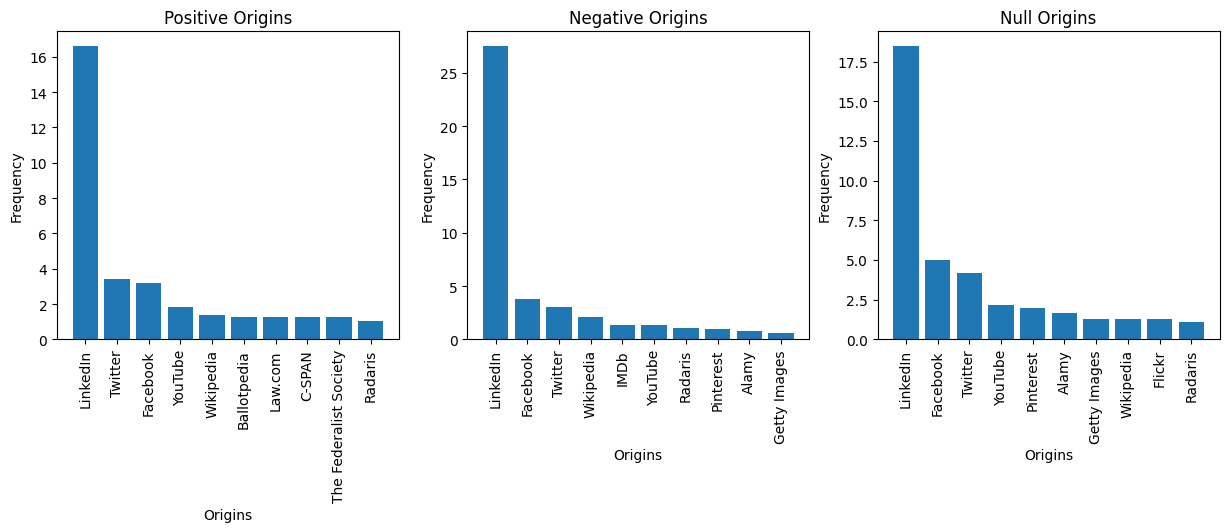

In [ ]:
positive_origins_count = positive_origins.groupby('Origin').count().reset_index().loc[:, ['Origin', 'File Name']].rename({'File Name':'Num'}, axis = 1).sort_values('Num', ascending = False).reset_index(drop = True)
positive_origins_count['Frequency'] = positive_origins_count['Num']*100/positive_origins_count['Num'].sum()
positive_origins_count = positive_origins_count.iloc[:10, :]

negative_origins_count = negative_origins.groupby('Origin').count().reset_index().loc[:, ['Origin', 'File Name']].rename({'File Name':'Num'}, axis = 1).sort_values('Num', ascending = False).reset_index(drop = True)
negative_origins_count['Frequency'] = negative_origins_count['Num']*100/negative_origins_count['Num'].sum()
negative_origins_count = negative_origins_count.iloc[:10, :]

null_origins_count = null_origins.groupby('Origin').count().reset_index().loc[:, ['Origin', 'File Name']].rename({'File Name':'Num'}, axis = 1).sort_values('Num', ascending = False).reset_index(drop = True)
null_origins_count['Frequency'] = null_origins_count['Num']*100/null_origins_count['Num'].sum()
null_origins_count = null_origins_count.iloc[:10, :]

plt.figure(figsize = (15,4))

plt.subplot(1,3,1)
plt.bar(positive_origins_count['Origin'], positive_origins_count['Frequency'])
plt.xticks(rotation = 90)
plt.title('Positive Origins')
plt.xlabel('Origins')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.bar(negative_origins_count['Origin'], negative_origins_count['Frequency'])
plt.xticks(rotation = 90)
plt.title('Negative Origins')
plt.xlabel('Origins')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
plt.bar(null_origins_count['Origin'], null_origins_count['Frequency'])
plt.xticks(rotation = 90)
plt.title('Null Origins')
plt.xlabel('Origins')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def origins_analysis(origins_data, comparisons_data):
  origins_comparison = pd.merge(origins_data, comparisons_data, on = 'File Name')
  positive_origins = origins_comparison[origins_comparison['Prediction'] == True].reset_index(drop = True)
  null_origins = origins_comparison[origins_comparison['Prediction'].isnull()].reset_index(drop = True)
  negative_origins = origins_comparison[origins_comparison['Prediction'] == False].reset_index(drop = True)

  positive_origins_count = positive_origins.groupby('Origin').count().reset_index().loc[:, ['Origin', 'File Name']].rename({'File Name':'Num'}, axis = 1).sort_values('Num', ascending = False).reset_index(drop = True)
  positive_origins_count['Frequency'] = positive_origins_count['Num']*100/positive_origins_count['Num'].sum()
  positive_origins_count = positive_origins_count.iloc[:10, :]

  negative_origins_count = negative_origins.groupby('Origin').count().reset_index().loc[:, ['Origin', 'File Name']].rename({'File Name':'Num'}, axis = 1).sort_values('Num', ascending = False).reset_index(drop = True)
  negative_origins_count['Frequency'] = negative_origins_count['Num']*100/negative_origins_count['Num'].sum()
  negative_origins_count = negative_origins_count.iloc[:10, :]

  null_origins_count = null_origins.groupby('Origin').count().reset_index().loc[:, ['Origin', 'File Name']].rename({'File Name':'Num'}, axis = 1).sort_values('Num', ascending = False).reset_index(drop = True)
  null_origins_count['Frequency'] = null_origins_count['Num']*100/null_origins_count['Num'].sum()
  null_origins_count = null_origins_count.iloc[:10, :]

  plt.figure(figsize = (15,4))

  plt.subplot(1,3,1)
  plt.bar(positive_origins_count['Origin'], positive_origins_count['Frequency'])
  plt.xticks(rotation = 90)
  plt.title('Positive Origins')
  plt.xlabel('Origins')
  plt.ylabel('Frequency')

  plt.subplot(1,3,2)
  plt.bar(negative_origins_count['Origin'], negative_origins_count['Frequency'])
  plt.xticks(rotation = 90)
  plt.title('Negative Origins')
  plt.xlabel('Origins')
  plt.ylabel('Frequency')

  plt.subplot(1,3,3)
  plt.bar(null_origins_count['Origin'], null_origins_count['Frequency'])
  plt.xticks(rotation = 90)
  plt.title('Null Origins')
  plt.xlabel('Origins')
  plt.ylabel('Frequency')
  plt.show()

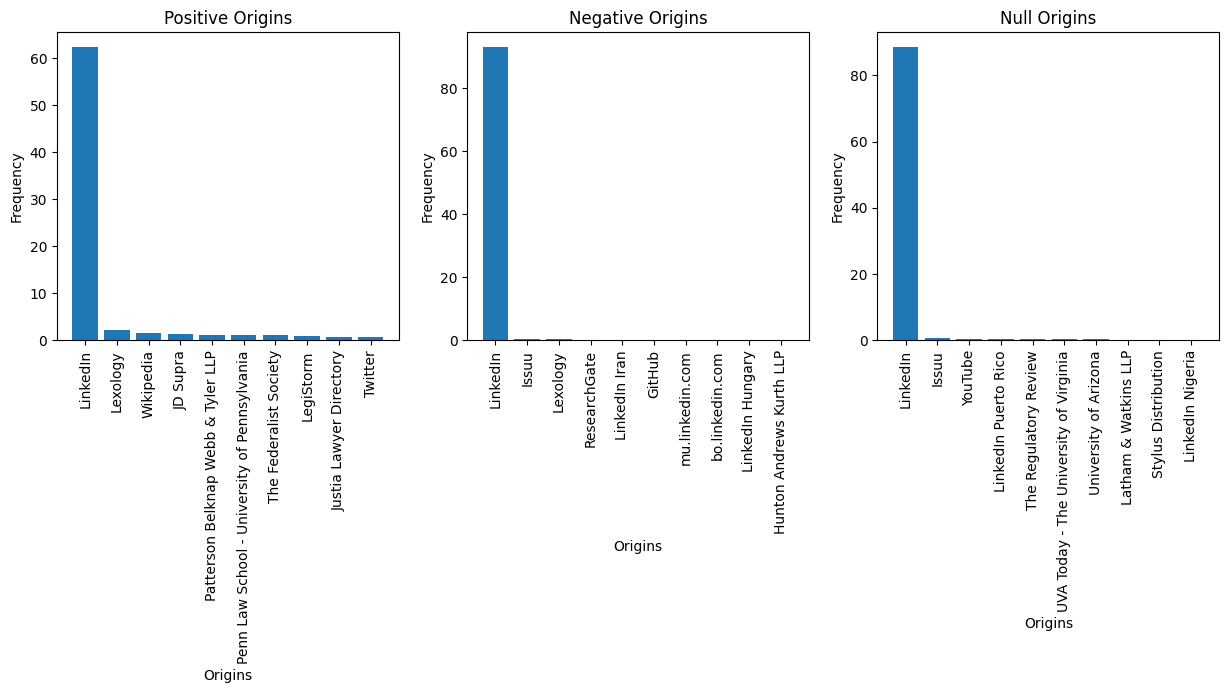

In [ ]:
origins_analysis(linkedin_10_origins, linkedin_10_comparisons)

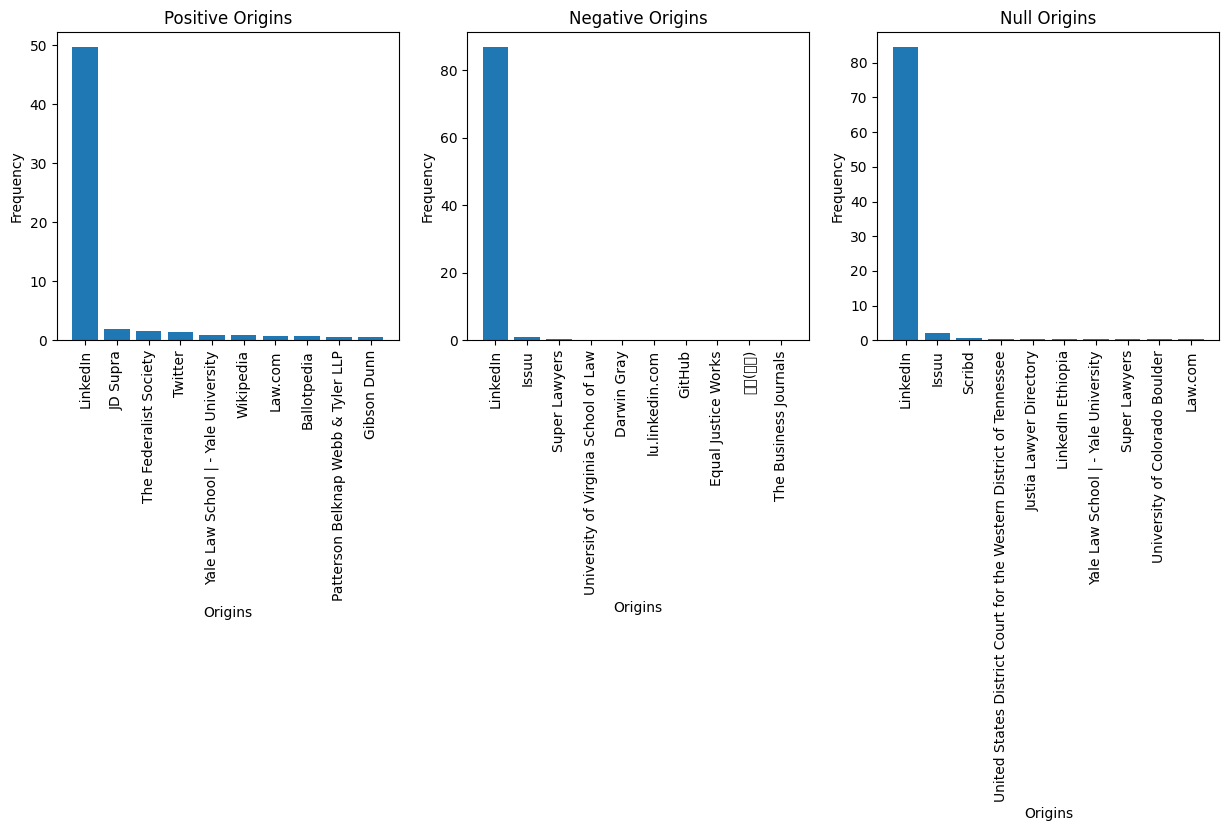

In [ ]:
origins_analysis(law_10_origins, law_10_comparisons)

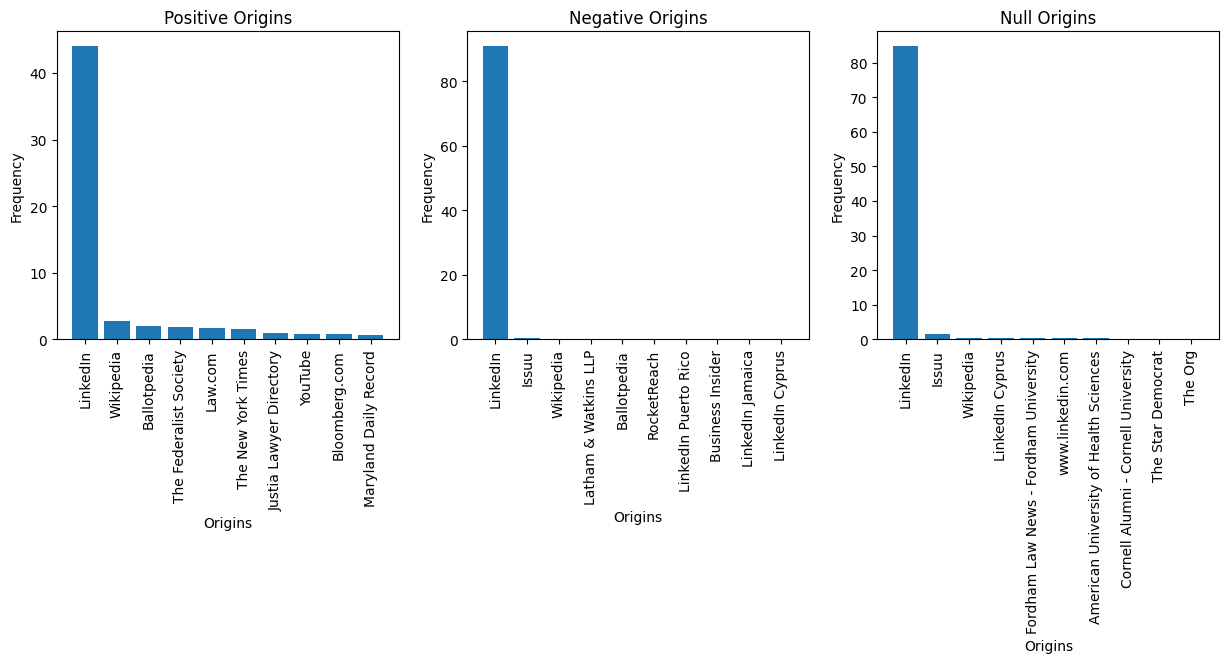

In [ ]:
origins_analysis(title_10_origins, title_10_comparisons)

# SIFT Features

## Preparation - Whole Pics

In [ ]:
arc_final = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv').drop('Unnamed: 0', axis = 1)
arc_final.head()

,Path_1,Path_2,Label,Prediction,Distance
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761
2,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842
3,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Naji_Sabri...,True,True,0.018809
4,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Gerhard_Sc...,False,False,0.819620


296
381
89


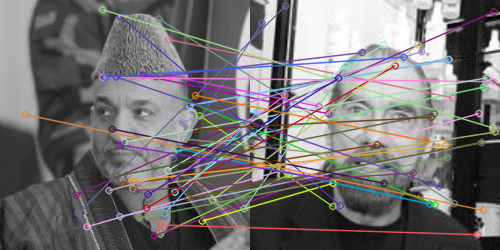

In [ ]:
img1 = cv2.imread(arc_final.loc[2, 'Path_1'])
img2 = cv2.imread(arc_final.loc[2, 'Path_2'])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# match descriptors of both images
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

print(len(descriptors_1))
print(len(descriptors_2))
print(len(matches))

matched_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
cv2_imshow(matched_img)

In [ ]:
n1 = 4000
n2 = 8000
n3 = 10000
descriptors_1 = []
descriptors_2 = []
matches = []

for i in tqdm(range(n3, arc_final.shape[0])):
  path_1 = arc_final.loc[i, 'Path_1']
  path_2 = arc_final.loc[i, 'Path_2']
  features_1, features_2, n_matches = sift_extraction(path_1, path_2)
  descriptors_1.append(features_1)
  descriptors_2.append(features_2)
  matches.append(n_matches)

arc = arc_final.loc[n3:, :]
arc['Descriptors_1'] = descriptors_1
arc['Descriptors_2'] = descriptors_2
arc['Matches'] = matches

arc.to_csv('/content/drive/MyDrive/ArcFace_Training_Set_4.csv')

100%|██████████| 4445/4445 [35:21<00:00,  2.10it/s]


In [ ]:
arc_1 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_1.csv')
arc_2 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_2.csv')
arc_3 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_3.csv')
arc_4 = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_4.csv')
arc_all = pd.concat([arc_1, arc_2, arc_3, arc_4]).drop('Unnamed: 0', axis = 1)
#arc_all.to_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv')
arc_all.head()

,Path_1,Path_2,Label,Prediction,Distance,Descriptors_1,Descriptors_2,Matches
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812,263,578,100
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761,263,240,59
2,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842,296,381,89
3,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Naji_Sabri...,True,True,0.018809,257,530,96
4,/content/drive/MyDrive/all_images_2/Naji_Sabri...,/content/drive/MyDrive/all_images_2/Gerhard_Sc...,False,False,0.819620,257,236,74


## Face Extraction

In [ ]:
arc_final = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv').drop('Unnamed: 0', axis = 1)
folder_to = '/content/drive/MyDrive/all_images_faces'
current_folder = '/content/drive/MyDrive/all_images_2'
all_images = os.listdir(current_folder)

paths = []
names = []

n1 = 4000
n2 = 8000

for i in tqdm(range(n1, len(all_images))):
  try:
    path = current_folder + '/' + all_images[i]
    embedding = df.represent(img_path = path, model_name = 'ArcFace')
    face_coord = embedding[0]['facial_area']
    x = face_coord['x']
    y = face_coord['y']
    w = face_coord['w']
    h = face_coord['h']

    image = cv2.imread(path)
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_color = image[y : y+h, x : x+w]
    path_to = folder_to + '/' + all_images[i]
    cv2.imwrite(path_to, roi_color)
    paths.append(path_to)
    names.append(all_images[i][:-9])

  except:
    paths.append(None)
    names.append(all_images[i][:-9])

all_faces = pd.DataFrame()
all_faces['Path'] = paths
all_faces['Name'] = names
all_faces.to_csv('/content/drive/MyDrive/all_faces_2.csv')

0it [00:00, ?it/s]


In [ ]:
faces_1 = pd.read_csv('/content/drive/MyDrive/all_faces_1.csv')
faces_2 = pd.read_csv('/content/drive/MyDrive/all_faces_2.csv')
all_faces = pd.concat([faces_1, faces_2]).drop('Unnamed: 0', axis = 1)
print(all_faces.shape)
all_faces.head()
#all_faces.to_csv('/content/drive/MyDrive/all_faces.csv')

(7609, 2)


,Path,Name
0,/content/drive/MyDrive/all_images_faces/Hamid_...,Hamid_Karzai
1,NaN,Colin_Powell
2,/content/drive/MyDrive/all_images_faces/Naji_S...,Naji_Sabri
3,/content/drive/MyDrive/all_images_faces/Junich...,Junichiro_Koizumi
4,/content/drive/MyDrive/all_images_faces/Colin_...,Colin_Powell


In [ ]:
all_faces = pd.read_csv('/content/drive/MyDrive/all_faces.csv')
null_faces = all_faces[all_faces['Path'].isnull()].shape[0]
print(f'% No Faces: {null_faces*100/all_faces.shape[0]}')

% No Faces: 2.6416086213694308


## Merging

In [ ]:
arc_final = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv').drop('Unnamed: 0', axis = 1)
all_faces = pd.read_csv('/content/drive/MyDrive/all_faces.csv').drop('Unnamed: 0', axis = 1)

names_1 = []
names_2 = []
print(arc_final.shape)

for i in range(arc_final.shape[0]):
    names_1.append(arc_final.loc[i, 'Path_1'].split('/')[-1])
    names_2.append(arc_final.loc[i, 'Path_2'].split('/')[-1])

arc_final['Name_1'] = names_1
arc_final['Name_2'] = names_2

faces_names = []
for i in range(all_faces.shape[0]):
    try:
        faces_names.append(all_faces.loc[i, 'Path'].split('/')[-1])
    except:
        faces_names.append(None)

all_faces['Name'] = faces_names

arc_final = pd.merge(arc_final, all_faces, left_on = 'Name_1', right_on = 'Name')
arc_final = pd.merge(arc_final, all_faces, left_on = 'Name_2', right_on = 'Name')
arc_final.drop(['Name_x', 'Name_y'], axis = 1, inplace = True)
arc_final.rename({'Path_x':'Path_1_Face', 'Path_y':'Path_2_Face'}, axis = 1, inplace = True)
print(arc_final.shape)
#arc_final.to_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv')
arc_final.head()

(14445, 8)
(14441, 12)


,Path_1,Path_2,Label,Prediction,Distance,Descriptors_1,Descriptors_2,Matches,Name_1,Name_2,Path_1_Face,Path_2_Face
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812,263,578,100,Sheryl_Crow_0008.jpg,Sheryl_Crow_0003.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Sheryl...
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.489551,292,578,89,Sheryl_Crow_0004.jpg,Sheryl_Crow_0003.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Sheryl...
2,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761,263,240,59,Sheryl_Crow_0008.jpg,Luiz_Inacio_Lula_da_Silva_0035.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Luiz_I...
3,/content/drive/MyDrive/all_images_2/Pamela_And...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.938135,411,240,87,Pamela_Anderson_0002.jpg,Luiz_Inacio_Lula_da_Silva_0035.jpg,/content/drive/MyDrive/all_images_faces/Pamela...,/content/drive/MyDrive/all_images_faces/Luiz_I...
4,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842,296,381,89,Hamid_Karzai_0021.jpg,John_Paul_DeJoria_0001.jpg,/content/drive/MyDrive/all_images_faces/Hamid_...,/content/drive/MyDrive/all_images_faces/John_P...


In [ ]:
arc_final = pd.read_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv').drop('Unnamed: 0', axis = 1)

n1 = 5000
n2 = 10000
descriptors_1 = []
descriptors_2 = []
matches = []

for i in tqdm(range(arc_final.shape[0])):
  path_1 = arc_final.loc[i, 'Path_1_Face']
  path_2 = arc_final.loc[i, 'Path_2_Face']
  if path_1 is not None and path_2 is not None:
    features_1, features_2, n_matches = sift_extraction(path_1, path_2)
    descriptors_1.append(features_1)
    descriptors_2.append(features_2)
    matches.append(n_matches)

arc_final['Descriptors_1_Face'] = descriptors_1
arc_final['Descriptors_2_Face'] = descriptors_2
arc_final['Matches_Face'] = matches

#arc_final.to_csv('/content/drive/MyDrive/ArcFace_Training_Set_Final.csv')

100%|██████████| 14441/14441 [07:18<00:00, 32.94it/s]


In [ ]:
arc_final.head()

,Path_1,Path_2,Label,Prediction,Distance,Descriptors_1,Descriptors_2,Matches,Name_1,Name_2,Path_1_Face,Path_2_Face,Descriptors_1_Face,Descriptors_2_Face,Matches_Face
0,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.566812,263,578,100,Sheryl_Crow_0008.jpg,Sheryl_Crow_0003.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Sheryl...,88,129,27
1,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,True,True,0.489551,292,578,89,Sheryl_Crow_0004.jpg,Sheryl_Crow_0003.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Sheryl...,109,129,34
2,/content/drive/MyDrive/all_images_2/Sheryl_Cro...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.915761,263,240,59,Sheryl_Crow_0008.jpg,Luiz_Inacio_Lula_da_Silva_0035.jpg,/content/drive/MyDrive/all_images_faces/Sheryl...,/content/drive/MyDrive/all_images_faces/Luiz_I...,88,114,45
3,/content/drive/MyDrive/all_images_2/Pamela_And...,/content/drive/MyDrive/all_images_2/Luiz_Inaci...,False,False,0.938135,411,240,87,Pamela_Anderson_0002.jpg,Luiz_Inacio_Lula_da_Silva_0035.jpg,/content/drive/MyDrive/all_images_faces/Pamela...,/content/drive/MyDrive/all_images_faces/Luiz_I...,71,114,33
4,/content/drive/MyDrive/all_images_2/Hamid_Karz...,/content/drive/MyDrive/all_images_2/John_Paul_...,False,False,0.802842,296,381,89,Hamid_Karzai_0021.jpg,John_Paul_DeJoria_0001.jpg,/content/drive/MyDrive/all_images_faces/Hamid_...,/content/drive/MyDrive/all_images_faces/John_P...,103,140,44
